In [4]:
%cd ..

/Users/gauransh/Code/PromptSLR


In [5]:
import pandas as pd
from utils.db_connector import DBConnector
import json
from results import BaseResults

In [8]:
class ProjectDataProcessor:
    def __init__(self, db):
        self.db = db

    def get_project_ids(self, project_names):
        """Fetch project IDs for given project names."""
        project_names = project_names if type(project_names) is list else [project_names]
        project_ids = self.db.db.projects.find_many(
            where={"Name": {"in": project_names}}
        )
        projects = {project_id.Name: project_id.ProjectID for project_id in project_ids}
        return projects

    def fetch_llm_decisions(self, project_id):
        """Fetch LLM decisions for a given project ID and convert them to a DataFrame."""
        decisions = self.db.db.llmdecisions.find_many(where={"ProjectID": project_id})
        decisions = [d.model_dump() for d in decisions]  # Convert to dictionary
        return pd.DataFrame(decisions)

    def prepare_project_dataframes(self, project_names):
        """Prepare dataframes for all projects."""
        projects = self.get_project_ids(project_names)
        print(projects)
        dfs = {}
        for project_name, project_id in projects.items():
            df = self.fetch_llm_decisions(project_id)
            df['is_true'] = df['Decision'].isin(['TP', 'TN'])
            dfs[project_name] = df
            
        return dfs

    def get_unknowns_by_decision(self, df):
        """Filter data by 'UK' decision and reset the index."""
        return df[df.Decision == "UK"].reset_index(drop=True)

    def parse_raw_output(self, df, suffix):
        """Parse the RawOutput JSON column and extract the 'ParsedDecision' from the JSON."""

        def extract_decision_from_json(raw_output):
            try:
                parsed_output = json.loads(raw_output)
                tmp = parsed_output.get("decision")
                print(tmp)
                return tmp
            except (json.JSONDecodeError, TypeError):
                return None

        df[f"ParsedDecision_{suffix}"] = df["RawOutput"].apply(
            extract_decision_from_json
        )
        df[f"Soft_{suffix}"] = df[f"ParsedDecision_{suffix}"].apply(
            lambda x: True if isinstance(x, str) and "MAYBE" in x else False
        )
        return df

    def compare_unknowns(self, df1, df2, suff_1, suff_2):
        """Compare two dataframes based on 'ArticleKey', merge results, and return the merged DataFrame."""
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)

        df1 = self.parse_raw_output(df1, suff_1)
        df2 = self.parse_raw_output(df2, suff_2)

        # Perform the merge on 'ArticleKey' to compare both dataframes
        merged_df = pd.merge(
            df1,
            df2[
                [
                    "ArticleKey",
                    "Confidence",
                    f"ParsedDecision_{suff_2}",
                    f"Soft_{suff_2}",
                ]
            ],
            on="ArticleKey",
            how="right",
        )
        # display(merged_df)
        return merged_df

    def parse_baseline_decision(self, key):
        """Map TP, FP, TN, FN to Include/Exclude decisions."""
        if key == "TP":
            return "Include".upper()
        elif key == "FP":
            return "Exclude".upper()
        elif key == "TN":
            return "Exclude".upper()
        elif key == "FN":
            return "Include".upper()
        return None

    def classify_decision(self, result_uX, u0, suffix):
        """Classify the comparison as TP, FP, TN, FN based on the baseline 'Decision' in u0."""

        def classify(row):
            baseline_decision = u0.loc[
                u0["ArticleKey"] == row["ArticleKey"], "Decision"
            ].values[
                0
            ]  # Baseline decision from u0
            ux_decision = row[f"ParsedDecision_{suffix}"]  # Parsed decision from uX
            # Compare baseline decision with uX decision
            if "INCLUDE" in ux_decision and "INCLUDE" in self.parse_baseline_decision(
                baseline_decision
            ):
                return "TP"  # True Positive
            elif "INCLUDE" in ux_decision and "EXCLUDE" in self.parse_baseline_decision(
                baseline_decision
            ):
                return "FP"  # False Positive
            elif "EXCLUDE" in ux_decision and "EXCLUDE" in self.parse_baseline_decision(
                baseline_decision
            ):
                return "TN"  # True Negative
            elif "EXCLUDE" in ux_decision and "INCLUDE" in self.parse_baseline_decision(
                baseline_decision
            ):
                return "FN"  # False Negative
            return None

        # Apply classification to each row in the result DataFrame
        result_uX[f"Classification_{suffix}"] = result_uX.apply(classify, axis=1)
        return result_uX


# Usage
def process_projects(project_names, db):
    """Main function to process projects and perform comparisons."""
    processor = ProjectDataProcessor(db)

    # Prepare the dataframes
    dfs = processor.prepare_project_dataframes(project_names)

    # Extract the unknown decisions for each project
    u0 = dfs[project_names[0]]  # Baseline dataframe
    u1_unknowns = dfs[project_names[1]]
    u2_unknowns = dfs[project_names[2]]
    u3_unknowns = dfs[project_names[3]]

    # Compare u0 with u1, u2, and u3 based on 'ArticleKey'
    result_u0_u1 = (
        processor.compare_unknowns(u0, u1_unknowns, "u0", "u1")
        if not u1_unknowns.empty
        else pd.DataFrame()
    )
    result_u0_u2 = (
        processor.compare_unknowns(u0, u2_unknowns, "u0", "u2")
        if not u2_unknowns.empty
        else pd.DataFrame()
    )
    result_u0_u3 = (
        processor.compare_unknowns(u0, u3_unknowns, "u0", "u3")
        if not u3_unknowns.empty
        else pd.DataFrame()
    )

    # Combine the results for final DataFrame output
    final_df = u0.copy()  # Use u0 as the base DataFrame

    if not result_u0_u1.empty:
        result_u0_u1 = processor.classify_decision(
            result_u0_u1, u0, "u1"
        )  # Pass u0 for baseline

    if not result_u0_u2.empty:
        result_u0_u2 = processor.classify_decision(
            result_u0_u2, u0, "u2"
        )  # Pass u0 for baseline

    if not result_u0_u3.empty:
        result_u0_u3 = processor.classify_decision(
            result_u0_u3, u0, "u3"
        )  # Pass u0 for baseline

    result_u0_u1.rename(
        columns={"Confidence_y": "Confidence_u1", "Confidence": "Confidence"},
        inplace=True,
    )
    result_u0_u2.rename(
        columns={"Confidence_y": "Confidence_u2", "Confidence": "Confidence"},
        inplace=True,
    )
    result_u0_u3.rename(
        columns={"Confidence_y": "Confidence_u3", "Confidence": "Confidence"},
        inplace=True,
    )

    final_df = pd.merge(
        final_df,
        result_u0_u1[
            [
                "ArticleKey",
                "Confidence_u1",
                "ParsedDecision_u1",
                "Soft_u1",
                "Classification_u1",
            ]
        ],
        on="ArticleKey",
        how="outer",
    )

    final_df = pd.merge(
        final_df,
        result_u0_u2[
            [
                "ArticleKey",
                "Confidence_u2",
                "ParsedDecision_u2",
                "Soft_u2",
                "Classification_u2",
            ]
        ],
        on="ArticleKey",
        how="outer",
    )

    final_df = pd.merge(
        final_df,
        result_u0_u3[
            [
                "ArticleKey",
                "Confidence_u3",
                "ParsedDecision_u3",
                "Soft_u3",
                "Classification_u3",
            ]
        ],
        on="ArticleKey",
        how="outer",
    )
    final_df.drop(
        [
            "LLMID",
            "Error",
            "Retries",
            "Iteration",
            "RawOutput",
            "Reason",
            "TokenUsed",
            "LLM",
            "Article",
            "Project",
        ],
        inplace=True,
        axis=1,
    )
    return result_u0_u1, result_u0_u2, result_u0_u3, u0, final_df
    # return result_u0_u2, final_df
def process_projects_2(project_names, db):
    """Main function to process projects and perform comparisons."""
    processor = ProjectDataProcessor(db)

    # Prepare the dataframes
    dfs = processor.prepare_project_dataframes(project_names)

    # Extract the unknown decisions for each project
    u0 = dfs[project_names[0]]  # Baseline dataframe
    u2_unknowns = dfs[project_names[1]]

    # Compare u0 with u1, u2, and u3 based on 'ArticleKey'

    result_u0_u2 = (
        processor.compare_unknowns(u0, u2_unknowns, "u0", "u2")
        if not u2_unknowns.empty
        else pd.DataFrame()
    )
    # Combine the results for final DataFrame output
    final_df = u0.copy()  # Use u0 as the base DataFrame

    if not result_u0_u2.empty:
        result_u0_u2 = processor.classify_decision(
            result_u0_u2, u0, "u2"
        )  # Pass u0 for baseline


    result_u0_u2.rename(
        columns={"Confidence_y": "Confidence_u2", "Confidence": "Confidence"},
        inplace=True,)
    final_df = pd.merge(
        final_df,
        result_u0_u2[
            [
                "ArticleKey",
                "Confidence_u2",
                "ParsedDecision_u2",
                "Soft_u2",
                "Classification_u2",
            ]
        ],
        on="ArticleKey",
        how="outer",
    )
    final_df.drop(
        [
            "LLMID",
            "Error",
            "Retries",
            "Iteration",
            "RawOutput",
            "Reason",
            "TokenUsed",
            "LLM",
            "Article",
            "Project",
        ],
        inplace=True,
        axis=1,
    )
    return result_u0_u2, final_df

In [24]:
# Example usage with project_names and a database connection instance
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-RL4SE-FINAL",
    "Std-U1-Cy-Rn-EXn-INn-A-SH0-EXPn-RL4SE-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RL4SE-FINAL",
    "Std-U3-Cy-Rn-EXn-INn-A-SH0-EXPn-RL4SE-FINAL",
]
_, _, _, _, final_df_rl4se = process_projects(project_names, db)

display(final_df_rl4se)  # Display the final DataFrame

{}


KeyError: 'Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-RL4SE-FINAL'

In [5]:
print( "RL4SE")
print( ">= 8 : ", final_df_rl4se[
     (final_df_rl4se["Confidence_u2"] >= 8)
].ParsedDecision_u2.value_counts().sort_index())
print( "=7 : ", final_df_rl4se[
     (final_df_rl4se["Confidence_u2"] == 7)
].ParsedDecision_u2.value_counts().sort_index())
print( "<= 6 : ", final_df_rl4se[
     (final_df_rl4se["Confidence_u2"] <= 6)
].ParsedDecision_u2.value_counts().sort_index())

RL4SE


NameError: name 'final_df_rl4se' is not defined

In [6]:
final_df_rl4se.ParsedDecision_u1.value_counts()

NameError: name 'final_df_rl4se' is not defined

In [7]:
final_df_rl4se.ParsedDecision_u2.value_counts()

NameError: name 'final_df_rl4se' is not defined

In [8]:
final_df_rl4se.ParsedDecision_u3.value_counts()

NameError: name 'final_df_rl4se' is not defined

In [9]:
final_df_rl4se.Decision.value_counts()
# U0

NameError: name 'final_df_rl4se' is not defined

In [10]:
final_df_rl4se.Classification_u2.value_counts()
# U2 with Soft

NameError: name 'final_df_rl4se' is not defined

In [11]:
final_df_rl4se[
    (final_df_rl4se["Soft_u2"] == True) & (final_df_rl4se["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index().sum()

NameError: name 'final_df_rl4se' is not defined

In [12]:
final_df_rl4se[
    (final_df_rl4se["Soft_u2"] == True) & (final_df_rl4se["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index().sum() / final_df_rl4se.shape[0]

NameError: name 'final_df_rl4se' is not defined

In [ ]:
final_df_rl4se[
    (final_df_rl4se["Soft_u2"] == True) & (final_df_rl4se["Confidence_u2"] <= 6.0)
].Classification_u2.value_counts().sort_index().sum()

260

In [190]:
final_df_rl4se[
     (final_df_rl4se["Confidence"] <= 7.0)
].Decision.value_counts().sort_index().sum()

520

In [191]:
final_df_rl4se[
     (final_df_rl4se["Confidence"] <= 7.0)
].Decision.value_counts().sort_index().sum() / final_df_rl4se.shape[0]

0.47750229568411384

In [192]:
final_df_rl4se[
     (final_df_rl4se["Confidence"] <= 6.0)
].Decision.value_counts().sort_index().sum()

8

In [193]:
final_df_rl4se[
     (final_df_rl4se["Confidence"] <= 6.0)
].Decision.value_counts().sort_index().sum() / final_df_rl4se.shape[0]

0.0073461891643709825

In [81]:
final_df_rl4se[final_df_rl4se["Soft_u2"] == True].Confidence_u2.value_counts()

Confidence_u2
5.0    220
4.0     21
6.0     19
Name: count, dtype: int64

In [82]:
final_df_rl4se[final_df_rl4se["Soft_u2"] == False].Confidence_u2.value_counts()

Confidence_u2
9.0     550
8.0     144
7.0     128
10.0      7
Name: count, dtype: int64

In [83]:
final_df_rl4se.Confidence_u2.value_counts().sort_index()

Confidence_u2
4.0      21
5.0     220
6.0      19
7.0     128
8.0     144
9.0     550
10.0      7
Name: count, dtype: int64

In [84]:
final_df_rl4se.Confidence.value_counts().sort_index()

Confidence
6.0       8
7.0     512
8.0      59
9.0     497
10.0     13
Name: count, dtype: int64

In [85]:
final_df_rl4se[final_df_rl4se["Confidence"] <= 6.0].Decision.value_counts().sort_index()

Decision
FP    8
Name: count, dtype: int64

In [86]:
final_df_rl4se[final_df_rl4se["Confidence"] >= 8.0].Decision.value_counts().sort_index()

Decision
FN      4
FP      6
TN    515
TP     44
Name: count, dtype: int64

In [87]:
final_df_rl4se[
    final_df_rl4se["Confidence_u2"] >= 8.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN      3
FP      8
TN    644
TP     46
Name: count, dtype: int64

In [177]:
final_df_rl4se[
    final_df_rl4se["Confidence_u2"] >= 7.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN      3
FP     53
TN    697
TP     76
Name: count, dtype: int64

In [178]:
final_df_rl4se[
    final_df_rl4se["Confidence_u2"] >= 6.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN      3
FP     64
TN    704
TP     77
Name: count, dtype: int64

In [179]:
final_df_rl4se[final_df_rl4se["Confidence"] >= 8.0].Decision.value_counts().sort_index()

Decision
FN      4
FP      6
TN    515
TP     44
Name: count, dtype: int64

In [180]:
final_df_rl4se[final_df_rl4se["Confidence"] >= 7.0].Decision.value_counts().sort_index()

Decision
FN      8
FP    121
TN    866
TP     86
Name: count, dtype: int64

In [181]:
final_df_rl4se[final_df_rl4se["Confidence"] >= 6.0].Decision.value_counts().sort_index()

Decision
FN      8
FP    129
TN    866
TP     86
Name: count, dtype: int64

In [88]:
final_df_rl4se[
    (final_df_rl4se["Soft_u2"] == True & (final_df_rl4se["Confidence_u2"] == 4.0))
]

,DecisionID,ArticleKey,ProjectID,Decision,Confidence,Confidence_u1,ParsedDecision_u1,Soft_u1,Classification_u1,Confidence_u2,ParsedDecision_u2,Soft_u2,Classification_u2,Confidence_u3,ParsedDecision_u3,Soft_u3,Classification_u3
2,32632,007b9b92-7541-4a65-a143-f39284ff9c2a,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
3,31969,008fd237-dfd7-4f11-a930-bbd91be07a34,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
4,32390,00a11135-ccd7-4c6c-986f-7f37bd6f44b1,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TN,10.0,9.0,EXCLUDE,False,TN,10.0,EXCLUDE,False,TN,10.0,EXCLUDE,False,TN
5,32416,00f5afc9-f35a-4391-bdff-619895486744,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TP,8.0,7.0,INCLUDE,False,TP,7.0,INCLUDE,False,TP,8.0,INCLUDE,False,TP
7,32058,01c389f3-ee2c-4e31-ba6a-23224ed31f6a,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TN,8.0,8.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,31933,fcb2667d-078a-4bd2-b330-a0180ec27084,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TN,7.0,7.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN
1084,31686,fd294128-2a52-41e0-8afb-a3e131e9fb9b,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
1085,31892,fe01f1f6-95e5-42ef-901d-b19cfa869277,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
1087,32529,ffa306da-e560-4a92-8866-89fe04769c8d,7e66cc56-0421-4edb-b4bb-f22a3bcf755c,TN,7.0,7.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN,6.0,MAYBE_INCLUDE,True,FP


In [71]:
a = db.db.articles.find_first(where={"Key": "007b9b92-7541-4a65-a143-f39284ff9c2a"})
print(a)
# db.get_articles()

Key='007b9b92-7541-4a65-a143-f39284ff9c2a' BibtexKey='Yang2022' Title='Hardware-aware Automated Architecture Search for Brain-inspired Hyperdimensional Computing' Abstract='Brain-inspired neural network, a.k.a., hyperdimensional computing (HDC), has been becoming a promising candidate for resource-limited edge computing, due to its small size and robustness. However, the previous HDC architecture exploration only considers the software aspects, like HDC operations. This paper presents a hardware-aware automated architecture search framework, namely HwAwHDC, for HDC, which can consider both hardware and software characters in a uniform reinforcement learning based optimization loop. It fills the gap in the automatic design of HDC architectures for given applications and hardware constraints. We do a thorough analysis to formulate the search spaces for HwAwHDC. On top of this, we design a hardware-friendly reward and employ reinforcement learning (RL) to explore the HDC architectures. Th

In [89]:
final_df_rl4se[final_df_rl4se["Soft_u2"] == True].Classification_u2.value_counts()
# U2 only soft

Classification_u2
FP    238
TP     15
TN      7
Name: count, dtype: int64

# LC

In [5]:
# Example usage with project_names and a database connection instance
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-LC-FINAL",
    "Std-U1-Cy-Rn-EXn-INn-A-SH0-EXPn-LC-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-LC-FINAL",
    "Std-U3-Cy-Rn-EXn-INn-A-SH0-EXPn-LC-FINAL",
]
_, _, _, _, final_df_lc = process_projects(project_names, db)

display(final_df_lc)  # Display the final DataFrame

,DecisionID,ArticleKey,ProjectID,Decision,Confidence,Confidence_u1,ParsedDecision_u1,Soft_u1,Classification_u1,Confidence_u2,ParsedDecision_u2,Soft_u2,Classification_u2,Confidence_u3,ParsedDecision_u3,Soft_u3,Classification_u3
0,44186,00029e82-3dd4-48a7-9d29-2d63598de3e2,e5a0304c-7b16-41c4-8658-ff72e6682706,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,5.0,MAYBE_INCLUDE,True,FP
1,46668,001f09f3-7e4a-47a7-842b-92377affa9e4,e5a0304c-7b16-41c4-8658-ff72e6682706,TN,8.0,7.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN
2,44995,0022192e-0667-4850-9c31-39ef1b97da3f,e5a0304c-7b16-41c4-8658-ff72e6682706,TN,8.0,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN
3,45327,003ef929-5f79-4ca0-bd24-f2ec738b9da3,e5a0304c-7b16-41c4-8658-ff72e6682706,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
4,46019,004e8a66-f94d-4285-8f2e-e2912d4441d0,e5a0304c-7b16-41c4-8658-ff72e6682706,TN,9.0,7.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,44397,ff751ab2-0eea-481a-a5c3-81fed063f40e,e5a0304c-7b16-41c4-8658-ff72e6682706,TN,10.0,10.0,EXCLUDE,False,TN,10.0,EXCLUDE,False,TN,10.0,EXCLUDE,False,TN
2679,45338,ff787eaf-9e5c-4f55-8f1e-c509aa1f04cf,e5a0304c-7b16-41c4-8658-ff72e6682706,TN,9.0,8.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN
2680,45735,ff9c71e2-07ae-46cc-a3f6-d4155f30ab00,e5a0304c-7b16-41c4-8658-ff72e6682706,FP,7.0,7.0,INCLUDE,False,FP,5.0,MAYBE_INCLUDE,True,FP,6.0,MAYBE_INCLUDE,True,FP
2681,44828,ffc4307c-12eb-4e07-8a35-ddd45b4829ac,e5a0304c-7b16-41c4-8658-ff72e6682706,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN


In [40]:
print( "LC")
print( ">= 8 : ", final_df_lc[
     (final_df_lc["Confidence_u2"] >= 8)
].ParsedDecision_u2.value_counts().sort_index())
print( "=7 : ", final_df_lc[
     (final_df_lc["Confidence_u2"] ==7)
].ParsedDecision_u2.value_counts().sort_index())
print( "<= 6 : ", final_df_lc[
     (final_df_lc["Confidence_u2"] <= 6)
].ParsedDecision_u2.value_counts().sort_index())

LC
>= 8 :  ParsedDecision_u2
EXCLUDE    1497
INCLUDE      32
Name: count, dtype: int64
=7 :  ParsedDecision_u2
EXCLUDE    477
INCLUDE    106
Name: count, dtype: int64
<= 6 :  ParsedDecision_u2
MAYBE_EXCLUDE     19
MAYBE_INCLUDE    552
Name: count, dtype: int64


In [100]:
final_df_lc.Decision.value_counts().sort_index()

Decision
FN      50
FP     193
TN    2340
TP     100
Name: count, dtype: int64

In [101]:
final_df_lc.Classification_u2.value_counts().sort_index()

Classification_u2
FN      18
FP     558
TN    1975
TP     132
Name: count, dtype: int64

In [102]:
final_df_lc.Confidence_u2.value_counts().sort_index()

Confidence_u2
4.0      38
5.0     421
6.0     112
7.0     583
8.0     570
9.0     763
10.0    196
Name: count, dtype: int64

In [194]:
final_df_lc.Confidence.value_counts().sort_index()

Confidence
6.0        1
7.0     1030
8.0      295
9.0     1064
10.0     293
Name: count, dtype: int64

In [103]:
final_df_lc[final_df_lc["Soft_u2"] == True].Confidence_u2.value_counts().sort_index()

Confidence_u2
4.0     38
5.0    421
6.0    112
Name: count, dtype: int64

In [104]:
final_df_lc[
    (final_df_lc["Confidence_u2"] >= 8.0)
].Classification_u2.value_counts().sort_index()

Classification_u2
FN       3
FP       9
TN    1494
TP      23
Name: count, dtype: int64

In [105]:
final_df_lc[
    (final_df_lc["Confidence_u2"] >= 7.0)
].Classification_u2.value_counts().sort_index()

Classification_u2
FN      18
FP      68
TN    1956
TP      70
Name: count, dtype: int64

In [108]:
final_df_lc[
    (final_df_lc["Confidence_u2"] >= 6.0)
].Classification_u2.value_counts().sort_index()

Classification_u2
FN      18
FP     139
TN    1973
TP      94
Name: count, dtype: int64

In [106]:
final_df_lc[(final_df_lc["Confidence"] >= 8.0)].Decision.value_counts().sort_index()

Decision
FN       4
FP      13
TN    1606
TP      29
Name: count, dtype: int64

In [107]:
final_df_lc[(final_df_lc["Confidence"] >= 7.0)].Decision.value_counts().sort_index()

Decision
FN      50
FP     192
TN    2340
TP     100
Name: count, dtype: int64

In [109]:
final_df_lc[(final_df_lc["Confidence"] >= 6.0)].Decision.value_counts().sort_index()

Decision
FN      50
FP     193
TN    2340
TP     100
Name: count, dtype: int64

In [47]:
final_df_lc[
     (final_df_lc["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index()

# find me

Classification_u2
FN     15
FP    549
TN    481
TP    109
Name: count, dtype: int64

In [48]:
final_df_lc[
     (final_df_lc["Confidence_u2"] >= 8.0)
].Classification_u2.value_counts().sort_index()

# find me

Classification_u2
FN       3
FP       9
TN    1494
TP      23
Name: count, dtype: int64

In [115]:
# IDK / N
(
    final_df_lc[
        (final_df_lc["Soft_u2"] == True) & (final_df_lc["Confidence_u2"] <= 7.0)
    ]
    .Classification_u2.value_counts()
    .sort_index()
    .sum()
    / final_df_lc.shape[0]
)

0.2128214685054044

In [117]:
final_df_lc[
    (final_df_lc["Soft_u2"] == True) & (final_df_lc["Confidence_u2"] <= 6.0)
].Classification_u2.value_counts().sort_index()

Classification_u2
FP    490
TN     19
TP     62
Name: count, dtype: int64

In [118]:
# IDK / N without soft
(
    final_df_lc[(final_df_lc["Confidence_u2"] <= 7.0)]
    .Classification_u2.value_counts()
    .sort_index()
    .sum()
    / final_df_lc.shape[0]
)

0.4301155423033917

In [119]:
# IDK / N
(
    final_df_lc[(final_df_lc["Confidence_u2"] <= 6.0)]
    .Classification_u2.value_counts()
    .sort_index()
    .sum()
    / final_df_lc.shape[0]
)

0.2128214685054044

In [120]:
# IDK / N without soft
(
    final_df_lc[(final_df_lc["Confidence"] <= 7.0)]
    .Decision.value_counts()
    .sort_index()
    .sum()
    / final_df_lc.shape[0]
)

0.3842713380544167

In [121]:
# IDK / N without soft
(
    final_df_lc[(final_df_lc["Confidence"] <= 6.0)]
    .Decision.value_counts()
    .sort_index()
    .sum()
    / final_df_lc.shape[0]
)

0.0003727171077152441

# MobileMDE

In [7]:
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-MOBILEMDE-FINAL",
    "Std-U1-Cy-Rn-EXn-INn-A-SH0-EXPn-MOBILEMDE-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-MOBILEMDE-FINAL",
    "Std-U3-Cy-Rn-EXn-INn-A-SH0-EXPn-MOBILEMDE-FINAL",
]
_, _, _, _, final_df_mobilemde = process_projects(project_names, db)

display(final_df_mobilemde)  # Display the final DataFrame

,DecisionID,ArticleKey,ProjectID,Decision,Confidence,Confidence_u1,ParsedDecision_u1,Soft_u1,Classification_u1,Confidence_u2,ParsedDecision_u2,Soft_u2,Classification_u2,Confidence_u3,ParsedDecision_u3,Soft_u3,Classification_u3
0,55799,02907c3c-5ccc-49bf-8bec-f7fc180d869a,542afa71-c7c4-4fae-9bcb-2294f5758726,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
1,55721,04bf40d8-7e50-431a-8dcd-44057bbf67a8,542afa71-c7c4-4fae-9bcb-2294f5758726,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
2,55905,05674a3d-befb-45e5-9ef6-eff5a0d678f1,542afa71-c7c4-4fae-9bcb-2294f5758726,FN,9.0,8.0,EXCLUDE,False,FN,8.0,EXCLUDE,False,FN,8.0,EXCLUDE,False,FN
3,55787,056f253e-1bda-4712-92e3-812d14afce36,542afa71-c7c4-4fae-9bcb-2294f5758726,TN,9.0,8.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN
4,55672,06d781d8-1d4c-44da-8e62-763759334e6f,542afa71-c7c4-4fae-9bcb-2294f5758726,TN,10.0,10.0,EXCLUDE,False,TN,10.0,EXCLUDE,False,TN,10.0,EXCLUDE,False,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,55912,f94c57ac-b9da-45f3-85b5-d45e45e41b7a,542afa71-c7c4-4fae-9bcb-2294f5758726,TN,9.0,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN
288,55643,f9d8c334-5b47-4bd8-a77f-833393588df2,542afa71-c7c4-4fae-9bcb-2294f5758726,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
289,55765,fb37f6fe-a1ce-45b8-8317-01f1666cfd11,542afa71-c7c4-4fae-9bcb-2294f5758726,TP,7.0,7.0,INCLUDE,False,TP,7.0,INCLUDE,False,TP,7.0,INCLUDE,False,TP
290,55714,fc0d45d4-6a03-44f2-bdd0-a562acf506c4,542afa71-c7c4-4fae-9bcb-2294f5758726,TP,9.0,9.0,INCLUDE,False,TP,9.0,INCLUDE,False,TP,9.0,INCLUDE,False,TP


In [41]:
print( "MOBILEMDE")
print( ">= 8 : ", final_df_mobilemde[
     (final_df_mobilemde["Confidence_u2"] >= 8)
].ParsedDecision_u2.value_counts().sort_index())
print( "=7 : ", final_df_mobilemde[
     (final_df_mobilemde["Confidence_u2"] ==7)
].ParsedDecision_u2.value_counts().sort_index())
print( "<= 6 : ", final_df_mobilemde[
     (final_df_mobilemde["Confidence_u2"] <= 6)
].ParsedDecision_u2.value_counts().sort_index())

MOBILEMDE
>= 8 :  ParsedDecision_u2
EXCLUDE    212
INCLUDE      7
Name: count, dtype: int64
=7 :  ParsedDecision_u2
EXCLUDE    27
INCLUDE    12
Name: count, dtype: int64
<= 6 :  ParsedDecision_u2
MAYBE_EXCLUDE     2
MAYBE_INCLUDE    32
Name: count, dtype: int64


In [123]:
final_df_mobilemde.Decision.value_counts().sort_index()

Decision
FN     33
FP      6
TN    231
TP     22
Name: count, dtype: int64

In [124]:
final_df_mobilemde.Classification_u2.value_counts().sort_index()

Classification_u2
FN     24
FP     20
TN    217
TP     31
Name: count, dtype: int64

In [125]:
final_df_mobilemde.Confidence.value_counts().sort_index()

Confidence
7.0      68
8.0       2
9.0     188
10.0     34
Name: count, dtype: int64

In [126]:
final_df_mobilemde.Confidence_u2.value_counts().sort_index()

Confidence_u2
5.0      26
6.0       8
7.0      39
8.0      37
9.0     149
10.0     33
Name: count, dtype: int64

In [128]:
final_df_mobilemde[
    (final_df_mobilemde["Confidence_u2"] >= 8.0)
].Classification_u2.value_counts().sort_index()

Classification_u2
FN     16
TN    196
TP      7
Name: count, dtype: int64

In [129]:
final_df_mobilemde[
    (final_df_mobilemde["Confidence_u2"] >= 7.0)
].Classification_u2.value_counts().sort_index()

Classification_u2
FN     22
FP      2
TN    217
TP     17
Name: count, dtype: int64

In [130]:
final_df_mobilemde[
    (final_df_mobilemde["Confidence_u2"] >= 6.0)
].Classification_u2.value_counts().sort_index()

Classification_u2
FN     24
FP      5
TN    217
TP     20
Name: count, dtype: int64

In [127]:
final_df_mobilemde[
    (final_df_mobilemde["Confidence"] >= 8.0)
].Decision.value_counts().sort_index()

Decision
FN     15
TN    202
TP      7
Name: count, dtype: int64

In [131]:
final_df_mobilemde[
    (final_df_mobilemde["Confidence"] >= 7.0)
].Decision.value_counts().sort_index()

Decision
FN     33
FP      6
TN    231
TP     22
Name: count, dtype: int64

In [132]:
final_df_mobilemde[
    (final_df_mobilemde["Confidence"] >= 6.0)
].Decision.value_counts().sort_index()

Decision
FN     33
FP      6
TN    231
TP     22
Name: count, dtype: int64

In [134]:
final_df_mobilemde[
    (final_df_mobilemde["Soft_u2"] == True)
    & (final_df_mobilemde["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index().sum()

34

In [135]:
final_df_mobilemde[
    (final_df_mobilemde["Soft_u2"] == True)
    & (final_df_mobilemde["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index().sum() / final_df_mobilemde.shape[0]

0.11643835616438356

In [136]:
final_df_mobilemde[
    (final_df_mobilemde["Soft_u2"] == True)
    & (final_df_mobilemde["Confidence_u2"] <= 6.0)
].Classification_u2.value_counts().sort_index().sum()

34

In [137]:
final_df_mobilemde[
    final_df_mobilemde["Confidence_u2"] <= 7.0
].Classification_u2.value_counts().sort_index().sum()

73

In [138]:
final_df_mobilemde[
    final_df_mobilemde["Confidence_u2"] <= 7.0
].Classification_u2.value_counts().sort_index().sum() / final_df_mobilemde.shape[0]

0.25

In [139]:
final_df_mobilemde[
    final_df_mobilemde["Confidence_u2"] <= 6.0
].Classification_u2.value_counts().sort_index().sum()

34

In [140]:
final_df_mobilemde[
    final_df_mobilemde["Confidence_u2"] <= 6.0
].Classification_u2.value_counts().sort_index().sum() / final_df_mobilemde.shape[0]

0.11643835616438356

# MPM4CPS

In [9]:
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL",
    "Std-U1-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL",
    "Std-U3-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL",
]
_, _, _, _, final_df_mpm4cps = process_projects(project_names, db)

display(final_df_mpm4cps)  # Display the final DataFrame

,DecisionID,ArticleKey,ProjectID,Decision,Confidence,Confidence_u1,ParsedDecision_u1,Soft_u1,Classification_u1,Confidence_u2,ParsedDecision_u2,Soft_u2,Classification_u2,Confidence_u3,ParsedDecision_u3,Soft_u3,Classification_u3
0,57519,00496d93-293d-4335-82c6-b2db01b7243b,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
1,57457,00bbe2bd-0baf-452a-aa01-bb6187d46314,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN
2,57492,00e4a12a-ce31-4acd-a021-d1a21a6a6c48,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,7.0,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN,5.0,MAYBE_INCLUDE,True,FP
3,57451,0169c866-158f-48d9-afad-c43bd21eaa9e,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TP,7.0,7.0,INCLUDE,False,TP,6.0,MAYBE_INCLUDE,True,TP,6.0,MAYBE_INCLUDE,True,TP
4,57556,019266a7-0f37-4fc3-ba0f-902674c31cfb,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,57445,fda4b10e-871d-41a7-b32d-8e0fd22008c9,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TP,7.0,7.0,INCLUDE,False,TP,7.0,INCLUDE,False,TP,7.0,INCLUDE,False,TP
201,57605,fde290a3-7b04-4b5a-aac0-a729d12811d3,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TP,7.0,7.0,INCLUDE,False,TP,6.0,MAYBE_INCLUDE,True,TP,7.0,INCLUDE,False,TP
202,57537,fe34dc83-fe7f-423b-9292-3aac29ed2d21,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN
203,57563,fe3e8c9f-af61-43ed-a22a-d8d239ff4b01,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN,8.0,EXCLUDE,False,TN


In [42]:
print( "MPM4CPS")
print( ">= 8 : ", final_df_mpm4cps[
     (final_df_mpm4cps["Confidence_u2"] >= 8)
].ParsedDecision_u2.value_counts().sort_index())
print( "=7 : ", final_df_mpm4cps[
     (final_df_mpm4cps["Confidence_u2"] ==7)
].ParsedDecision_u2.value_counts().sort_index())
print( "<= 6 : ", final_df_mpm4cps[
     (final_df_mpm4cps["Confidence_u2"] <= 6)
].ParsedDecision_u2.value_counts().sort_index())

MPM4CPS
>= 8 :  ParsedDecision_u2
EXCLUDE    69
INCLUDE    19
Name: count, dtype: int64
=7 :  ParsedDecision_u2
EXCLUDE    29
INCLUDE    22
Name: count, dtype: int64
<= 6 :  ParsedDecision_u2
MAYBE_EXCLUDE     4
MAYBE_INCLUDE    62
Name: count, dtype: int64


In [53]:
final_df_mpm4cps[
     (final_df_mpm4cps["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index()

# find me

Classification_u2
FN    11
FP    24
TN    22
TP    60
Name: count, dtype: int64

In [142]:
final_df_mpm4cps.Decision.value_counts().sort_index()

Decision
FN    57
FP    13
TN    85
TP    50
Name: count, dtype: int64

In [143]:
final_df_mpm4cps.Classification_u2.value_counts().sort_index()

Classification_u2
FN    29
FP    25
TN    73
TP    78
Name: count, dtype: int64

In [144]:
final_df_mpm4cps.Confidence.value_counts().sort_index()

Confidence
7.0     128
8.0      18
9.0      58
10.0      1
Name: count, dtype: int64

In [145]:
final_df_mpm4cps.Confidence_u2.value_counts().sort_index()

Confidence_u2
5.0     42
6.0     24
7.0     51
8.0     42
9.0     45
10.0     1
Name: count, dtype: int64

In [146]:
final_df_mpm4cps[
    final_df_mpm4cps["Confidence_u2"] >= 8.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN    18
FP     1
TN    51
TP    18
Name: count, dtype: int64

In [147]:
final_df_mpm4cps[
    final_df_mpm4cps["Confidence_u2"] >= 7.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN    27
FP     5
TN    71
TP    36
Name: count, dtype: int64

In [148]:
final_df_mpm4cps[
    final_df_mpm4cps["Confidence_u2"] >= 6.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN    29
FP    11
TN    73
TP    50
Name: count, dtype: int64

In [149]:
final_df_mpm4cps[
    final_df_mpm4cps["Confidence"] >= 8.0
].Decision.value_counts().sort_index()

Decision
FN    12
TN    47
TP    18
Name: count, dtype: int64

In [150]:
final_df_mpm4cps[
    final_df_mpm4cps["Confidence"] >= 7.0
].Decision.value_counts().sort_index()

Decision
FN    57
FP    13
TN    85
TP    50
Name: count, dtype: int64

In [151]:
final_df_mpm4cps[
    final_df_mpm4cps["Confidence"] >= 6.0
].Decision.value_counts().sort_index()

Decision
FN    57
FP    13
TN    85
TP    50
Name: count, dtype: int64

In [155]:
final_df_mpm4cps[
    (final_df_mpm4cps["Soft_u2"] == True) & (final_df_mpm4cps["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index().sum()

66

In [156]:
final_df_mpm4cps[
    (final_df_mpm4cps["Soft_u2"] == True) & (final_df_mpm4cps["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index().sum() / final_df_mpm4cps.shape[0]

0.32195121951219513

In [157]:
final_df_mpm4cps[
    (final_df_mpm4cps["Soft_u2"] == True) & (final_df_mpm4cps["Confidence_u2"] <= 6.0)
].Classification_u2.value_counts().sort_index().sum()

66

In [158]:
final_df_mpm4cps[
    (final_df_mpm4cps["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index().sum()

117

In [159]:
final_df_mpm4cps[
    (final_df_mpm4cps["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index().sum() / final_df_mpm4cps.shape[0]

0.5707317073170731

In [160]:
final_df_mpm4cps[
    (final_df_mpm4cps["Confidence_u2"] <= 6.0)
].Classification_u2.value_counts().sort_index().sum()

66

# UpdateCollabMDE

In [11]:
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-UPDATECOLLABMDE-FINAL",
    "Std-U1-Cy-Rn-EXn-INn-A-SH0-EXPn-UPDATECOLLABMDE-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-UPDATECOLLABMDE-FINAL",
    "Std-U3-Cy-Rn-EXn-INn-A-SH0-EXPn-UPDATECOLLABMDE-FINAL",
]
_, _, _, _, final_df_updatecollabmde = process_projects(project_names, db)

display(final_df_updatecollabmde)  # Display the final DataFrame

,DecisionID,ArticleKey,ProjectID,Decision,Confidence,Confidence_u1,ParsedDecision_u1,Soft_u1,Classification_u1,Confidence_u2,ParsedDecision_u2,Soft_u2,Classification_u2,Confidence_u3,ParsedDecision_u3,Soft_u3,Classification_u3
0,60931,0000e73b-8920-4288-a232-8a0aade363c7,f6f66194-cea7-41e6-a432-072ff7b32c33,FP,7.0,7.0,INCLUDE,False,FP,7.0,INCLUDE,False,FP,7.0,INCLUDE,False,FP
1,61315,00a6c20e-612c-48a5-8d44-4c383cad4c98,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,7.0,EXCLUDE,False,TN,5.0,MAYBE_INCLUDE,True,FP,5.0,MAYBE_INCLUDE,True,FP
2,61699,00a93f41-712a-46e4-a08f-f7c39b535f7b,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN
3,61025,00b65ad2-92ce-4bc9-a734-f564df805f67,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,7.0,EXCLUDE,False,TN,5.0,MAYBE_INCLUDE,True,FP,5.0,MAYBE_INCLUDE,True,FP
4,61518,015668b6-d4e2-4984-9745-dbb8d3910d25,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,9.0,7.0,EXCLUDE,False,TN,9.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,61102,fe82990e-d7e8-4c73-8b3d-d2c4ea9eae57,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN
871,61088,fe8b19e7-9446-4a53-b1ac-187881118b99,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,10.0,10.0,EXCLUDE,False,TN,10.0,EXCLUDE,False,TN,10.0,EXCLUDE,False,TN
872,61282,ff6e3b3e-1038-42ab-a8de-115ea90e5c46,f6f66194-cea7-41e6-a432-072ff7b32c33,FP,7.0,7.0,INCLUDE,False,FP,7.0,INCLUDE,False,FP,7.0,INCLUDE,False,FP
873,61252,ff9630d2-dcd9-423c-a7f4-fe861069141b,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN,7.0,EXCLUDE,False,TN


In [43]:
print( "UPDATECOLLABMDE")
print( ">= 8 : ", final_df_updatecollabmde[
     (final_df_updatecollabmde["Confidence_u2"] >= 8)
].ParsedDecision_u2.value_counts().sort_index())
print( "=7 : ", final_df_updatecollabmde[
     (final_df_updatecollabmde["Confidence_u2"] ==7)
].ParsedDecision_u2.value_counts().sort_index())
print( "<= 6 : ", final_df_updatecollabmde[
     (final_df_updatecollabmde["Confidence_u2"] <= 6)
].ParsedDecision_u2.value_counts().sort_index())

UPDATECOLLABMDE
>= 8 :  ParsedDecision_u2
EXCLUDE    198
INCLUDE     24
Name: count, dtype: int64
=7 :  ParsedDecision_u2
EXCLUDE    449
INCLUDE     39
Name: count, dtype: int64
<= 6 :  ParsedDecision_u2
MAYBE_EXCLUDE      5
MAYBE_INCLUDE    160
Name: count, dtype: int64


In [51]:
final_df_updatecollabmde[
     (final_df_updatecollabmde["Confidence_u2"] <= 7.0)
].Classification_u2.value_counts().sort_index()

# find me

Classification_u2
FN      9
FP    160
TN    445
TP     39
Name: count, dtype: int64

In [162]:
final_df_updatecollabmde.Decision.value_counts().sort_index()

Decision
FN     22
FP     66
TN    752
TP     35
Name: count, dtype: int64

In [163]:
final_df_updatecollabmde.Classification_u2.value_counts().sort_index()

Classification_u2
FN     11
FP    177
TN    641
TP     46
Name: count, dtype: int64

In [164]:
final_df_updatecollabmde[
    final_df_updatecollabmde["Confidence_u2"] >= 8.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN      2
FP     17
TN    196
TP      7
Name: count, dtype: int64

In [165]:
final_df_updatecollabmde[
    final_df_updatecollabmde["Confidence_u2"] >= 7.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN     11
FP     41
TN    636
TP     22
Name: count, dtype: int64

In [166]:
final_df_updatecollabmde[
    final_df_updatecollabmde["Confidence_u2"] >= 6.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN     11
FP     54
TN    640
TP     33
Name: count, dtype: int64

In [168]:
final_df_updatecollabmde[final_df_updatecollabmde["Confidence" ]>= 8.0].Decision.value_counts().sort_index()

Decision
FN      1
FP     16
TN    194
TP      6
Name: count, dtype: int64

In [169]:
final_df_updatecollabmde[final_df_updatecollabmde["Confidence" ]>= 7.0].Decision.value_counts().sort_index()

Decision
FN     22
FP     66
TN    752
TP     35
Name: count, dtype: int64

In [170]:
final_df_updatecollabmde[final_df_updatecollabmde["Confidence" ]>= 6.0].Decision.value_counts().sort_index()

Decision
FN     22
FP     66
TN    752
TP     35
Name: count, dtype: int64

In [171]:
final_df_updatecollabmde[(final_df_updatecollabmde["Soft_u2"] == True) & (final_df_updatecollabmde["Confidence_u2"] <= 7.0)].Classification_u2.value_counts().sort_index().sum()

165

In [172]:
final_df_updatecollabmde[(final_df_updatecollabmde["Soft_u2"] == True) & (final_df_updatecollabmde["Confidence_u2"] <= 7.0)].Classification_u2.value_counts().sort_index().sum() / final_df_updatecollabmde.shape[0]

0.18857142857142858

In [173]:
final_df_updatecollabmde[(final_df_updatecollabmde["Soft_u2"] == True) & (final_df_updatecollabmde["Confidence_u2"] <= 6.0)].Classification_u2.value_counts().sort_index().sum()

165

In [174]:
final_df_updatecollabmde[(final_df_updatecollabmde["Confidence_u2"] <= 7.0)].Classification_u2.value_counts().sort_index().sum()

653

In [175]:
final_df_updatecollabmde[(final_df_updatecollabmde["Confidence_u2"] <= 7.0)].Classification_u2.value_counts().sort_index().sum() / final_df_updatecollabmde.shape[0]

0.7462857142857143

In [176]:
final_df_updatecollabmde[(final_df_updatecollabmde["Confidence_u2"] <= 6.0)].Classification_u2.value_counts().sort_index().sum()

165

In [15]:
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-LC-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-LC-FINAL-GPT-4-TURBO",
]
_, final_df_lc_cot = process_projects_2(project_names, db)

display(final_df_lc_cot)  # Display the final DataFrame

KeyError: "None of [Index(['ArticleKey', 'Confidence_u2', 'ParsedDecision_u2', 'Soft_u2',\n       'Classification_u2'],\n      dtype='object')] are in the [columns]"

In [44]:
print( "LC COT")
print( ">= 8 : ", final_df_lc_cot[
     (final_df_lc_cot["Confidence_u2"] >= 8)
].ParsedDecision_u2.value_counts().sort_index())
print( "=7 : ", final_df_lc_cot[
     (final_df_lc_cot["Confidence_u2"] ==7)
].ParsedDecision_u2.value_counts().sort_index())
print( "<= 6 : ", final_df_lc_cot[
     (final_df_lc_cot["Confidence_u2"] <= 6)
].ParsedDecision_u2.value_counts().sort_index())

LC COT
>= 8 :  ParsedDecision_u2
EXCLUDE    1662
INCLUDE     278
Name: count, dtype: int64
=7 :  ParsedDecision_u2
INCLUDE          21
MAYBE_EXCLUDE     1
Name: count, dtype: int64
<= 6 :  ParsedDecision_u2
MAYBE_EXCLUDE    120
MAYBE_INCLUDE    601
Name: count, dtype: int64


In [31]:
final_df_lc_cot[
    final_df_lc_cot["Confidence_u2"] >= 8.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN       9
FP     179
TN    1653
TP      99
Name: count, dtype: int64

In [32]:
final_df_lc_cot[
    final_df_lc_cot["Confidence_u2"] <= 7.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN      3
FP    583
TN    118
TP     39
Name: count, dtype: int64

In [15]:
db.db.projects.find_first(where={"Name": {"in": [ "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-LC-FINAL-GPT-4-TURBO"]}})

Projects(ProjectID='b1c446c9-fb75-4c21-83e3-f2b43fa62038', Name='Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-LC-FINAL-GPT-4-TURBO', Iteration=1, TopicTitle='Domain-specific modeling language composition', TopicDescription='approaches and techniques for composing heterogeneous domain-specific modeling languages', ContextTokens=336, LLMs=None, Datasets=None, Configurations=None, LLMDecisions=None, ProjectDatasets=None, ProjectShots=None)

In [17]:
print(str(db.db.configurations.find_first(where={"ProjectID": "b1c446c9-fb75-4c21-83e3-f2b43fa62038"}).RenderedPromptContext))

You are an expert in conducting a systematic literature review (SLR) on domain-specific modeling language (DSML) composition. This SLR  investigates approaches and techniques for composing heterogeneous domain-specific modeling languages. The study should focus exclusively on this topic.

 

Your task is determining whether articles should be included or excluded from the SLR. I give you the TITLE, ABSTRACT as input.

Be lenient. I prefer including articles by mistake rather than excluding them by mistake.

 

Follow these steps when making your decisions:

1. Determine the topic relevance: Is the article related to DSMLs and their composition? Does the article address the composition of non-modeling languages?

2. Evaluate if the article helps in answering the research questions: What are the trends of DSML composition in the literature? What are the characteristics of DSML composition techniques? What tool support is there for DSML composition? How are the DSML composition approaches

In [23]:
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-UPDATECOLLABMDE-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-UPDATECOLLABMDE-FINAL-GPT-4-TURBO",
]
_, final_df_update_cot = process_projects_2(project_names, db)

display(final_df_update_cot)  # Display the final DataFrame

,DecisionID,ArticleKey,ProjectID,Decision,Confidence,Confidence_u2,ParsedDecision_u2,Soft_u2,Classification_u2
0,60931,0000e73b-8920-4288-a232-8a0aade363c7,f6f66194-cea7-41e6-a432-072ff7b32c33,FP,7.0,5.0,MAYBE_INCLUDE,True,FP
1,61315,00a6c20e-612c-48a5-8d44-4c383cad4c98,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,7.0,INCLUDE,False,FP
2,61699,00a93f41-712a-46e4-a08f-f7c39b535f7b,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,8.0,EXCLUDE,False,TN
3,61025,00b65ad2-92ce-4bc9-a734-f564df805f67,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,8.0,INCLUDE,False,FP
4,61518,015668b6-d4e2-4984-9745-dbb8d3910d25,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,9.0,9.0,EXCLUDE,False,TN
...,...,...,...,...,...,...,...,...,...
870,61102,fe82990e-d7e8-4c73-8b3d-d2c4ea9eae57,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,8.0,EXCLUDE,False,TN
871,61088,fe8b19e7-9446-4a53-b1ac-187881118b99,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,10.0,10.0,EXCLUDE,False,TN
872,61282,ff6e3b3e-1038-42ab-a8de-115ea90e5c46,f6f66194-cea7-41e6-a432-072ff7b32c33,FP,7.0,6.0,MAYBE_INCLUDE,True,FP
873,61252,ff9630d2-dcd9-423c-a7f4-fe861069141b,f6f66194-cea7-41e6-a432-072ff7b32c33,TN,7.0,8.0,EXCLUDE,False,TN


In [34]:
print( "UPDATECOLLABMDE COT")
print( ">= 8 : ", final_df_update_cot[
     (final_df_update_cot["Confidence_u2"] >= 8)
].ParsedDecision_u2.value_counts().sort_index())
print( "=7 : ", final_df_update_cot[
     (final_df_update_cot["Confidence_u2"] ==7)
].ParsedDecision_u2.value_counts().sort_index())
print( "<= 6 : ", final_df_update_cot[
     (final_df_update_cot["Confidence_u2"] <= 6)
].ParsedDecision_u2.value_counts().sort_index())

UPDATECOLLABMDE COT
>= 8 :  726
=7 :  13
<= 6 :  136


In [28]:
final_df_update_cot[
    final_df_update_cot["Confidence_u2"] >= 8.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN     10
FP     57
TN    627
TP     32
Name: count, dtype: int64

In [29]:
final_df_update_cot[
    final_df_update_cot["Confidence_u2"] <= 7.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN     1
FP    95
TN    39
TP    14
Name: count, dtype: int64

In [26]:
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL-GPT-4-TURBO",
]
_, final_df_mpm_cot = process_projects_2(project_names, db)

display(final_df_mpm_cot)  # Display the final DataFrame

,DecisionID,ArticleKey,ProjectID,Decision,Confidence,Confidence_u2,ParsedDecision_u2,Soft_u2,Classification_u2
0,57519,00496d93-293d-4335-82c6-b2db01b7243b,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN
1,57457,00bbe2bd-0baf-452a-aa01-bb6187d46314,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,8.0,EXCLUDE,False,TN
2,57492,00e4a12a-ce31-4acd-a021-d1a21a6a6c48,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,7.0,6.0,MAYBE_EXCLUDE,True,TN
3,57451,0169c866-158f-48d9-afad-c43bd21eaa9e,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TP,7.0,6.0,MAYBE_INCLUDE,True,TP
4,57556,019266a7-0f37-4fc3-ba0f-902674c31cfb,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN
...,...,...,...,...,...,...,...,...,...
200,57445,fda4b10e-871d-41a7-b32d-8e0fd22008c9,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TP,7.0,8.0,INCLUDE,False,TP
201,57605,fde290a3-7b04-4b5a-aac0-a729d12811d3,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TP,7.0,8.0,INCLUDE,False,TP
202,57537,fe34dc83-fe7f-423b-9292-3aac29ed2d21,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN
203,57563,fe3e8c9f-af61-43ed-a22a-d8d239ff4b01,2a044bb0-90e1-417f-a5c2-aeb589bb3253,TN,9.0,9.0,EXCLUDE,False,TN


In [28]:
print("MPM4CPS COT")
print( ">= 8 : ", final_df_mpm_cot[
     (final_df_mpm_cot["Confidence_u2"] >= 8)
].Classification_u2.value_counts().sort_index().sum())
print( "=7 : ", final_df_mpm_cot[
     (final_df_mpm_cot["Confidence_u2"] ==7)
].Classification_u2.value_counts().sort_index().sum())
print( "<= 6 : ", final_df_mpm_cot[
     (final_df_mpm_cot["Confidence_u2"] <= 6)
].Classification_u2.value_counts().sort_index().sum())

MPM4CPS COT
>= 8 :  137
=7 :  3
<= 6 :  65


In [22]:
final_df_mpm_cot[
    final_df_mpm_cot["Confidence_u2"] >= 8.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN    19
FP     8
TN    60
TP    50
Name: count, dtype: int64

In [23]:
final_df_mpm_cot[
    final_df_mpm_cot["Confidence_u2"] <= 7.0
].Classification_u2.value_counts().sort_index()

Classification_u2
FN    11
FP    20
TN    10
TP    27
Name: count, dtype: int64

In [ ]:
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL-GPT-4-TURBO",
]
_, final_df_mpm_cot = process_projects_2(project_names, db)

display(final_df_mpm_cot)  # Display the final DataFrame

In [5]:
db = DBConnector()  # Assuming your DBConnector instance
project_names = [
    "Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL",
    "Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO",
]
_, final_df_mpm_cot = process_projects_2(project_names, db)

display(final_df_mpm_cot)  # Display the final DataFrame

KeyError: 'Std-U0-Cy-Rn-EXn-INn-A-SH0-EXPn-MPM4CPS-FINAL'

In [16]:
db = DBConnector()
tmp = db.get_articles(db.get_datasetid("lc_golden"))
datasets = {}
original_decision_lc = {}
for i in tmp:
    original_decision_lc[i.Key] = i.ScreenedDecision.upper()
datasets["LC"] = original_decision_lc
tmp = db.get_articles(db.get_datasetid("mpm4cps_golden"))
original_decision_mpm4cps = {}
for i in tmp:
    original_decision_mpm4cps[i.Key] = i.ScreenedDecision.upper()
datasets["MPM4CPS"] = original_decision_mpm4cps
tmp = db.get_articles(db.get_datasetid("updatecollabmde_golden"))
original_decision_updatecollabmde = {}
for i in tmp:
    original_decision_updatecollabmde[i.Key] = i.ScreenedDecision.upper()
datasets["UPDATECOLLABMDE"] = original_decision_updatecollabmde
tmp = db.get_articles(db.get_datasetid("gamesefinal_golden"))
original_decision_gamesefinal = {}
for i in tmp:
    original_decision_gamesefinal[i.Key] = i.ScreenedDecision.upper()
datasets["GAMESEFINAL"] = original_decision_gamesefinal
tmp = db.get_articles(db.get_datasetid("esm2_golden"))
original_decision_esm2 = {}
for i in tmp:
    original_decision_esm2[i.Key] = i.ScreenedDecision.upper()
datasets["ESM2"] = original_decision_esm2
tmp = db.get_articles(db.get_datasetid("testnn_golden"))
original_decision_testnn = {}
for i in tmp:
    original_decision_testnn[i.Key] = i.ScreenedDecision.upper()
datasets["TESTNN"] = original_decision_testnn

AttributeError: 'NoneType' object has no attribute 'DatasetID'

In [9]:
def calcul_heatmap(df, data_original):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    for i in df.itertuples():
        if i.ParsedDecision_U2 in data_original[i.ArticleKey]:
            if "INCLUDE" in i.ParsedDecision_U2:
                tp +=1
            elif "EXCLUDE" in i.ParsedDecision_U2 :
                tn +=1
        else:
            if "INCLUDE" in i.ParsedDecision_U2:
                fp +=1
            elif "EXCLUDE" in i.ParsedDecision_U2:
                fn +=1
    print(tp, tn, fp, fn)
    return {"tp":tp, "tn":tn, "fp":fp, "fn":fn}

def print_results(df, ds):
    res = BaseResults()
    res.set_result_values(**calcul_heatmap(df,ds))
    
    print(f"{df.ParsedDecision_U2.value_counts().sort_index().sum()}\t{res.get_balanced_accuracy():.4f}\t{res.get_precision():.4f}\t{res.get_npv():.4f}\t{res.get_recall():.4f}\t{res.get_specificity():.4f}")


In [10]:
def prepare_results(id_pr_string):
    ds = ['LC', 'MPM4CPS', 'UPDATECOLLABMDE', 'GAMESEFINAL', 'ESM2', 'TESTNN']
    for i in ds:
        print(i)
        local_processor = ProjectDataProcessor(db)
        id_pr = id_pr_string.format(i)
        df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
        df = local_processor.parse_raw_output(df, 'U2')
        
        df_tmp =  df[
        (df["Confidence"] >= 9)
        ]
        if df_tmp.shape[0] == 0:
            print("0\t0.0000\t0.0000\t0.0000\t0.0000\t0.0000")
        else:
            print_results(df_tmp, datasets[i])
        df_tmp =  df[
        (df["Confidence"] >= 8)
        ]
        if df_tmp.shape[0] == 0:
            print("0\t0.0000\t0.0000\t0.0000\t0.0000\t0.0000")
        else:
            print_results(df_tmp, datasets[i])
        df_tmp =  df[
        (df["Confidence"] == 7)
        ]
        if df_tmp.shape[0] == 0:
            print("0\t0.0000\t0.0000\t0.0000\t0.0000\t0.0000")
        else:
            print_results(df_tmp, datasets[i])
        df_tmp =  df[
        (df["Confidence"] <= 6)
        ]
        if df_tmp.shape[0] == 0:
            print("0\t0.0000\t0.0000\t0.0000\t0.0000\t0.0000")
        else:
            print_results(df_tmp, datasets[i])
        print_results(df, datasets[i])
        print("\n")
    
        

In [9]:
prepare_results('Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-DEEPSEEKPROMPT-{}-FINAL-LLAMAFILE')

LC


NameError: name 'db' is not defined

In [17]:
prepare_results('Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO')

NameError: name 'prepare_results' is not defined

In [18]:
prepare_results('Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO')

NameError: name 'prepare_results' is not defined

In [8]:
prepare_results('Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO')

LC
283	0.9585	0.6923	0.9961	0.9474	0.9697
1433	0.8353	0.2308	0.9978	0.9840	0.6865
561	0.7970	0.0663	0.9973	0.9286	0.6654
688	0.0053	0.0000	0.2059	0.0000	0.0106
2682	0.6618	0.0983	0.9769	0.8193	0.5044


MPM4CPS
21	0.7500	0.8947	1.0000	1.0000	0.5000
138	0.7043	0.7500	0.9545	0.9886	0.4200
34	0.5750	0.4000	0.7500	0.4000	0.7500
32	0.0000	0.0000	0.0000	0.0000	0.0000
204	0.6482	0.5759	0.8478	0.9286	0.3679


UPDATECOLLABMDE
46	0.7917	0.4000	1.0000	1.0000	0.5833
440	0.8609	0.3083	0.9935	0.9535	0.7683
161	0.5995	0.1111	0.9803	0.2500	0.9490
273	0.0000	0.0000	0.0000	0.0000	0.0000
874	0.4516	0.1364	0.8021	0.2727	0.6306


GAMESEFINAL
4	0.7500	0.6667	1.0000	1.0000	0.5000
423	0.5174	0.4464	0.7273	0.9676	0.0672
154	0.5667	0.3952	0.8000	0.8909	0.2424
35	0.0000	0.0000	0.0000	0.0000	0.0000
612	0.5269	0.4079	0.7547	0.9461	0.1078


ESM2
4	0.5000	0.7500	0.0000	1.0000	0.0000
71	0.5423	0.6000	0.6667	0.9512	0.1333
20	0.6250	0.5000	0.7500	0.7500	0.5000
22	0.0000	0.0000	0.0000	0.0000	0.0000
113	0.5373	0.4545	0.71

In [19]:
prepare_results('Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO')

NameError: name 'prepare_results' is not defined

In [10]:
prepare_results('Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO')

LC
520	0.9625	0.7600	0.9957	0.9500	0.9750
2515	0.8296	0.2075	0.9895	0.8639	0.7952
55	0.7130	0.0312	1.0000	1.0000	0.4259
112	0.0000	0.0000	0.0000	0.0000	0.0000
2682	0.8058	0.1695	0.9891	0.8591	0.7525


MPM4CPS
23	0.9643	0.9000	1.0000	1.0000	0.9286
167	0.7374	0.8448	0.6789	0.5833	0.8916
11	0.5208	0.2857	0.7500	0.6667	0.3750
26	0.0000	0.0000	0.0000	0.0000	0.0000
204	0.6222	0.5604	0.6814	0.5862	0.6581


UPDATECOLLABMDE
82	0.4878	0.0000	1.0000	0.0000	0.9756
811	0.8278	0.3333	0.9829	0.7500	0.9056
29	0.5000	0.0000	0.8966	0.0000	1.0000
34	0.0000	0.0000	0.0000	0.0000	0.0000
874	0.7650	0.2609	0.9742	0.6545	0.8755


GAMESEFINAL
19	0.5571	0.3333	0.7692	0.4000	0.7143
549	0.6838	0.6545	0.7346	0.5682	0.7994
37	0.6389	0.5938	1.0000	1.0000	0.2778
26	0.0000	0.0000	0.0000	0.0000	0.0000
612	0.6599	0.5830	0.7342	0.5975	0.7224


ESM2
1	0.5000	1.0000	0.0000	1.0000	0.0000
98	0.5284	0.5667	0.5000	0.3333	0.7234
1	0.0000	0.0000	0.0000	0.0000	0.0000
14	0.0000	0.0000	0.0000	0.0000	0.0000
113	0.4422	0.3864	0.4928	0

In [20]:
prepare_results('Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO')

NameError: name 'prepare_results' is not defined

In [15]:
prepare_results('Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO')

LC
319	0.9630	0.7059	0.9965	0.9600	0.9660
2128	0.8136	0.1678	0.9948	0.9485	0.6787
378	0.5881	0.0388	0.9818	0.4444	0.7317
176	0.0057	0.0000	1.0000	0.0000	0.0114
2682	0.7787	0.1272	0.9927	0.9172	0.6401


MPM4CPS
26	0.8688	0.8824	0.8889	0.9375	0.8000
167	0.7605	0.7683	0.7529	0.7500	0.7711
12	0.7857	1.0000	0.6250	0.5714	1.0000
25	0.0000	0.0000	0.0000	0.0000	0.0000
204	0.6722	0.6091	0.7340	0.7283	0.6161


UPDATECOLLABMDE
83	0.4940	0.0000	1.0000	0.0000	0.9880
748	0.7969	0.3261	0.9787	0.6818	0.9119
75	0.6920	0.2727	0.9531	0.5000	0.8841
51	0.0000	0.0000	0.0000	0.0000	0.0000
874	0.7395	0.2185	0.9723	0.6226	0.8563


GAMESEFINAL
3	0.3333	0.0000	1.0000	0.0000	0.6667
435	0.7321	0.6772	0.7942	0.6524	0.8118
165	0.5862	0.5970	0.5816	0.4938	0.6786
12	0.0000	0.0000	0.0000	0.0000	0.0000
612	0.6774	0.6203	0.7387	0.6000	0.7548


ESM2
1	0.5000	1.0000	0.0000	1.0000	0.0000
96	0.5522	0.6250	0.5139	0.3000	0.8043
9	0.6250	1.0000	0.6250	0.2500	1.0000
8	0.0000	0.0000	0.0000	0.0000	0.0000
113	0.5041	0.4848	0.5250	0

In [21]:
print("LC RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())

LC RQy SH0 Simple


NameError: name 'df' is not defined

In [115]:
res = BaseResults()
df =  df[
     (df["Confidence"] >= 8)
]
res.set_result_values(**calcul_heatmap(df, original_decision_lc))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

Precision:  0.3557692307692308
Recall:  0.9736842105263158
NPV:  0.9977859778597786
Specificity:  0.8705730843528654


In [22]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')

DataError: Timed out fetching a new connection from the connection pool. More info: http://pris.ly/d/connection-pool (Current connection pool timeout: 10, connection limit: 13)

In [ ]:
print("MPM4CPS RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())

MPM4CPS RQy SH0 Simple
>= 8 :  112
=7 :  5
<= 6 :  88


In [118]:
res = BaseResults()
df =  df[
     (df["Confidence"] >= 8)
]
res.set_result_values(**calcul_heatmap(df, original_decision_mpm4cps))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

Precision:  0.8064516129032258
Recall:  0.8333333333333334
NPV:  0.8
Specificity:  0.7692307692307693


In [119]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')

In [120]:
print("UPDATECOLLABMDE RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())

UPDATECOLLABMDE RQy SH0 Simple
>= 8 :  531
=7 :  160
<= 6 :  184


In [121]:
res = BaseResults()
df =  df[
     (df["Confidence"] >= 8)
]
res.set_result_values(**calcul_heatmap(df, original_decision_updatecollabmde))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

Precision:  0.4050632911392405
Recall:  0.8421052631578947
NPV:  0.9867256637168141
Specificity:  0.9046653144016227


In [93]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')

In [94]:
print("LC RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())

LC RQy SH0 Simple
>= 8 :  1566
=7 :  414
<= 6 :  702


In [95]:
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_lc))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

Precision:  0.09158751696065129
Recall:  0.8282208588957055
NPV:  0.9768211920529801
Specificity:  0.4684398570861453


In [96]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("MPM4CPS RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())

MPM4CPS RQy SH0 Simple
>= 8 :  128
=7 :  23
<= 6 :  53


In [97]:
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_mpm4cps))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

Precision:  0.515527950310559
Recall:  0.9222222222222223
NPV:  0.8372093023255814
Specificity:  0.3157894736842105


In [98]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("UPDATECOLLABMDE RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())

UPDATECOLLABMDE RQy SH0 Simple
>= 8 :  629
=7 :  94
<= 6 :  151


In [99]:
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_updatecollabmde))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

Precision:  0.16433566433566432
Recall:  0.47474747474747475
NPV:  0.9115646258503401
Specificity:  0.6916129032258065


In [100]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-LC-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("LC RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_lc))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())




LC RQy SH0 Simple
>= 8 :  1394
=7 :  267
<= 6 :  1022
Precision:  0.08641975308641975
Recall:  0.5544554455445545
NPV:  0.9351117519826965
Specificity:  0.5227730753728336


In [101]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("MPM4CPS RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_mpm4cps))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())


MPM4CPS RQy SH0 Simple
>= 8 :  113
=7 :  12
<= 6 :  80
Precision:  0.4041095890410959
Recall:  0.7763157894736842
NPV:  0.711864406779661
Specificity:  0.32558139534883723


In [102]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("UPDATECOLLABMDE RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_updatecollabmde))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())


UPDATECOLLABMDE RQy SH0 Simple
>= 8 :  607
=7 :  103
<= 6 :  165
Precision:  0.16170212765957448
Recall:  0.42696629213483145
NPV:  0.9203125
Specificity:  0.7493638676844784


In [103]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-LC-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("LC RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_lc))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())


LC RQy SH0 Simple
>= 8 :  1433
=7 :  561
<= 6 :  688
Precision:  0.09833694866232827
Recall:  0.8192771084337349
NPV:  0.976905311778291
Specificity:  0.5043720190779014


In [104]:

local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("MPM4CPS RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_mpm4cps))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())


MPM4CPS RQy SH0 Simple
>= 8 :  138
=7 :  34
<= 6 :  32
Precision:  0.5759493670886076
Recall:  0.9285714285714286
NPV:  0.8478260869565217
Specificity:  0.36792452830188677


In [105]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("UPDATECOLLABMDE RQy SH0 Simple")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_updatecollabmde))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())


UPDATECOLLABMDE RQy SH0 Simple
>= 8 :  440
=7 :  161
<= 6 :  273
Precision:  0.13636363636363635
Recall:  0.2727272727272727
NPV:  0.8021201413427562
Specificity:  0.6305555555555555


In [123]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("LC RQy SH1 SELECTION")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_lc))
df =  df[
     (df["Confidence"] >= 8)
]
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())


LC RQy SH1 SELECTION
>= 8 :  2515
=7 :  55
<= 6 :  112
Precision:  0.1695364238410596
Recall:  0.8590604026845637
NPV:  0.9891022314478464
Specificity:  0.7524674299249902


In [124]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-UPDATECOLLABMDE-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("UPDATECOLLABMDE RQy SH1 SELECTION")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
df =  df[
     (df["Confidence"] >= 8)
]
res.set_result_values(**calcul_heatmap(df, original_decision_updatecollabmde))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())


UPDATECOLLABMDE RQy SH1 SELECTION
>= 8 :  811
=7 :  29
<= 6 :  34
Precision:  0.3333333333333333
Recall:  0.75
NPV:  0.9829302987197724
Specificity:  0.9056356487549148


In [125]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-MPM4CPS-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("MPM4CPS RQy SH1 SELECTION")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
df =  df[
     (df["Confidence"] >= 8)
]
res.set_result_values(**calcul_heatmap(df, original_decision_mpm4cps))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

MPM4CPS RQy SH1 SELECTION
>= 8 :  167
=7 :  11
<= 6 :  26
Precision:  0.8448275862068966
Recall:  0.5833333333333334
NPV:  0.6788990825688074
Specificity:  0.891566265060241


In [126]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-LC-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("LC RQy SH1 COT")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
df =  df[
     (df["Confidence"] >= 8)
]
res.set_result_values(**calcul_heatmap(df, original_decision_lc))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

LC RQy SH1 COT
>= 8 :  2128
=7 :  378
<= 6 :  176
Precision:  0.16775032509752927
Recall:  0.9485294117647058
NPV:  0.9948491537895512
Specificity:  0.678714859437751


In [27]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-UPDATECOLLABMDE-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("UPDATECOLLABMDE RQy SH1 COT")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
res.set_result_values(**calcul_heatmap(df, original_decision_updatecollabmde))
df =  df[
     (df["Confidence"] >= 8)
]
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

KeyError: 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-UPDATECOLLABMDE-FINAL-GPT-4-TURBO'

In [26]:
local_processor = ProjectDataProcessor(db)
id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-MPM4CPS-FINAL-GPT-4-TURBO'
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')
print("MPM4CPS RQy SH1 COT")
print( ">= 8 : ", df[
     (df["Confidence"] >= 8)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "=7 : ", df[
     (df["Confidence"] ==7)
].ParsedDecision_U2.value_counts().sort_index().sum())
print( "<= 6 : ", df[
     (df["Confidence"] <= 6)
].ParsedDecision_U2.value_counts().sort_index().sum())
res = BaseResults()
df =  df[
     (df["Confidence"] >= 8)
]
df.head()
res.set_result_values(**calcul_heatmap(df, original_decision_mpm4cps))
print("Precision: ", res.get_precision())
print("Recall: ", res.get_recall())
print("NPV: ", res.get_npv())
print("Specificity: ", res.get_specificity())

KeyError: 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-MPM4CPS-FINAL-GPT-4-TURBO'

In [28]:
from scipy.stats import mannwhitneyu, spearmanr
from db_connector import DBConnector
import pandas as pd
db = DBConnector()

In [23]:
from scipy.stats import mannwhitneyu, spearmanr
from db_connector import DBConnector
import pandas as pd
db = DBConnector()
projects_for_manwhitney = [
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
]
datasets =  ['LC', 'MPM4CPS', "UPDATECOLLABMDE", "GAMESEFINAL", "ESM2", "TESTNN",'ESPLE', 'SECSELFADAPT', 'SMELLREPROD', 'BEHAVE', 'DTCPS', 'TRUSTSE']

In [24]:
# datasets = ['LC', 'MPM4CPS', "UPDATECOLLABMDE", "GAMESEFINAL", "ESM2", "TESTNN"]

In [25]:
local_processor = ProjectDataProcessor(db)
id_pr = projects_for_manwhitney[0].format(datasets[2])
df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
df = local_processor.parse_raw_output(df, 'U2')

{'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-UPDATECOLLABMDE-FINAL-GPT-4-TURBO': '3ee6af9c-12e6-4c13-819d-2970fb0cf7c7'}
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUD

In [26]:
df.head()

,DecisionID,LLMID,ArticleKey,ProjectID,Decision,Error,Retries,Iteration,RawOutput,Reason,Confidence,TokenUsed,LLM,Article,Project,is_true,ParsedDecision_U2,Soft_U2
0,45782,42,422dd921-b467-4466-aa34-67ba14ab8623,3ee6af9c-12e6-4c13-819d-2970fb0cf7c7,TP,False,0,0,"{""decision"": ""INCLUDE"", ""confidence"": 8}",None,8.0,393,None,None,None,True,INCLUDE,False
1,45783,42,d583b10f-e496-48fe-a08b-659c68c7399b,3ee6af9c-12e6-4c13-819d-2970fb0cf7c7,TN,False,0,0,"{""decision"": ""EXCLUDE"", ""confidence"": 9}",None,9.0,414,None,None,None,True,EXCLUDE,False
2,45784,42,4ce0e64f-d0cf-455c-b954-81a6c713a0e5,3ee6af9c-12e6-4c13-819d-2970fb0cf7c7,TN,False,0,0,"{""decision"": ""EXCLUDE"", ""confidence"": 8}",None,8.0,397,None,None,None,True,EXCLUDE,False
3,45785,42,8da79e7f-d97a-4527-9592-580df9d0263f,3ee6af9c-12e6-4c13-819d-2970fb0cf7c7,TN,False,0,0,"{""decision"": ""EXCLUDE"", ""confidence"": 8}",None,8.0,429,None,None,None,True,EXCLUDE,False
4,45786,42,e96240c7-bcd7-425f-a6e9-4959d95c0754,3ee6af9c-12e6-4c13-819d-2970fb0cf7c7,TN,False,0,0,"{""decision"": ""EXCLUDE"", ""confidence"": 9}",None,9.0,406,None,None,None,True,EXCLUDE,False


In [27]:
from scipy.stats import mannwhitneyu, spearmanr
from db_connector import DBConnector
import pandas as pd
db = DBConnector()
projects_for_manwhitney = [
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
]
datasets =  ['LC', 'MPM4CPS', "UPDATECOLLABMDE", "GAMESEFINAL", "ESM2", "TESTNN",'ESPLE', 'SECSELFADAPT', 'SMELLREPROD', 'BEHAVE', 'DTCPS', 'TRUSTSE']
df_for_manwhitney = pd.DataFrame(columns=["Project","Prompt","Dataset", "Article", "Confidence", "Decision","is_true"])
dfs_new = {}
for d in datasets:
    for n in projects_for_manwhitney:
        name = n.format(d)
        db = DBConnector()
        local_processor = ProjectDataProcessor(db)
        df = local_processor.prepare_project_dataframes(name)[name]
        df = local_processor.parse_raw_output(df, 'U2')
        prompt_name =  name.split("-")[0] +"-" + name.split("-")[1]+"-" +name.split("-")[2]+"-" + name.split("-")[7]+"-" + name.split("-")[9]+"-" + name.split("-")[10]
        df_for_manwhitney = pd.concat([df_for_manwhitney, df[["ArticleKey", "Confidence", "is_true", "Decision"]].assign(Project=name, Dataset=name.split("-")[11], Prompt=prompt_name)], axis=0)
        dfs_new[name] = df[['ArticleKey', 'Confidence', 'is_true']]


{'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO': '1a712f76-a683-4649-a822-c6f37bf47d0e'}
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INC

In [31]:
dfs_new['Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO'].head()

,ArticleKey,Confidence,is_true
0,ab52616c-c867-46c2-a753-d0d054b03cc8,9.0,True
1,9a50750e-d524-4039-99bc-92b42fbbd715,8.0,True
2,34dd9ba5-b285-4b96-86eb-defc855648c3,8.0,True
3,246baf8e-c7cf-436a-889c-0cb3f47d9da3,9.0,True
4,41f275e9-8dd3-49b9-805b-2cfb05181fd2,9.0,True


In [34]:
from scipy.stats import mannwhitneyu, spearmanr
from db_connector import DBConnector
import pandas as pd
db = DBConnector()
projects_for_manwhitney = [
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
]
datasets = ['LC', 'MPM4CPS', "UPDATECOLLABMDE", "GAMESEFINAL", "ESM2", "TESTNN"]
df_for_manwhitney = pd.DataFrame(columns=["Project","Prompt","Dataset", "Article", "Confidence", "Decision","is_true"])
dfs_new = {}
for d in datasets:
    for n in projects_for_manwhitney:
        name = n.format(d)
        db = DBConnector()
        local_processor = ProjectDataProcessor(db)
        df = local_processor.prepare_project_dataframes(name)[name]
        df = local_processor.parse_raw_output(df, 'U2')
        prompt_name =  name.split("-")[0] +"-" + name.split("-")[1]+"-" +name.split("-")[2]+"-" + name.split("-")[7]+"-" + name.split("-")[9]+"-" + name.split("-")[10]
        df_for_manwhitney = pd.concat([df_for_manwhitney, df[["ArticleKey", "Confidence", "is_true", "Decision"]].assign(Project=name, Dataset=name.split("-")[11], Prompt=prompt_name)], axis=0)
        dfs_new[name] = df[['ArticleKey', 'Confidence', 'is_true']]

df_for_manwhitney['Article'] = df_for_manwhitney['ArticleKey']
df_for_manwhitney = df_for_manwhitney.drop(columns=['ArticleKey'])
df_for_manwhitney.head()

,Project,Prompt,Dataset,Article,Confidence,Decision,is_true
0,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-...,Std-U2-Cy-SH0-RQy-SIMPLE,LC,10b8a793-5b5d-4b61-8412-3c7881d71bcc,8.0,TN,True
1,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-...,Std-U2-Cy-SH0-RQy-SIMPLE,LC,ab52616c-c867-46c2-a753-d0d054b03cc8,8.0,TN,True
2,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-...,Std-U2-Cy-SH0-RQy-SIMPLE,LC,9a50750e-d524-4039-99bc-92b42fbbd715,8.0,TN,True
3,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-...,Std-U2-Cy-SH0-RQy-SIMPLE,LC,34dd9ba5-b285-4b96-86eb-defc855648c3,8.0,TN,True
4,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-...,Std-U2-Cy-SH0-RQy-SIMPLE,LC,246baf8e-c7cf-436a-889c-0cb3f47d9da3,8.0,TN,True


In [35]:

df_for_manwhitney['Confidence'].value_counts()

Confidence
8.0     21978
5.0      5874
7.0      3677
9.0      2298
10.0     2092
6.0      1095
4.0       265
3.0        13
2.0         4
Name: count, dtype: int64

In [36]:
df_for_manwhitney['is_true'].astype('int').value_counts()

is_true
1    23026
0    14270
Name: count, dtype: int64

array(['Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-MPM4CPS-FINAL-GPT-4-TURBO',
       'St

In [97]:
from scipy.stats import mannwhitneyu, spearmanr
from db_connector import DBConnector
import pandas as pd
db = DBConnector()
projects_for_manwhitney = [
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
]
datasets = ['LC', 'MPM4CPS', "UPDATECOLLABMDE", "GAMESEFINAL", "ESM2", "TESTNN"]
df_for_manwhitney = pd.DataFrame(columns=["Project","Prompt","Dataset", "Article", "Confidence", "Decision","is_true"])
dfs_new = {}
for d in datasets:
    for n in projects_for_manwhitney:
        name = n.format(d)
        db = DBConnector()
        local_processor = ProjectDataProcessor(db)
        df = local_processor.prepare_project_dataframes(name)[name]
        df = local_processor.parse_raw_output(df, 'U2')
        prompt_name =  name.split("-")[0] +"-" + name.split("-")[1]+"-" +name.split("-")[2]+"-" + name.split("-")[7]+"-" + name.split("-")[9]+"-" + name.split("-")[10]
        df_for_manwhitney = pd.concat([df_for_manwhitney, df[["ArticleKey", "Confidence", "is_true", "Decision"]].assign(Project=name, Dataset=name.split("-")[11], Prompt=prompt_name)], axis=0)
        dfs_new[name] = df[['ArticleKey', 'Confidence', 'is_true']]

df_for_manwhitney['Article'] = df_for_manwhitney['ArticleKey']
df_for_manwhitney = df_for_manwhitney.drop(columns=['ArticleKey'])
df_for_manwhitney.head()
def get_binary_count(df):
    # Check the current distribution of 'is_true'
    df.groupby('Confidence')['is_true'].value_counts()

    # Ensure 'is_true' is binary (0 or 1)
    df['is_true'] = df['is_true'].apply(lambda x: 1 if x else 0)

    # Convert 'is_true' to integer type (if not already binary)
    df['is_true'] = df['is_true'].astype(int)

    # Get the binary counts for each unique 'Confidence'
    binary_counts = df.groupby('Confidence')['is_true'].value_counts()

    # Or, get overall binary counts directly
    overall_binary_counts = df['is_true'].value_counts()

    return binary_counts


In [16]:
from scipy.stats import mannwhitneyu, spearmanr
from db_connector import DBConnector
import pandas as pd
db = DBConnector()
projects_for_manwhitney = [
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
]
datasets = ['LC', 'MPM4CPS', "UPDATECOLLABMDE", "GAMESEFINAL", "ESM2", "TESTNN",'ESPLE', 'SECSELFADAPT', 'SMELLREPROD', 'BEHAVE', 'DTCPS', 'TRUSTSE']
df_for_manwhitney = pd.DataFrame(columns=["Project","Prompt","Dataset", "Article", "Confidence", "Decision","is_true"])
dfs_new = {}
for d in datasets:
    for n in projects_for_manwhitney:
        name = n.format(d)
        db = DBConnector()
        local_processor = ProjectDataProcessor(db)
        df = local_processor.prepare_project_dataframes(name)[name]
        df = local_processor.parse_raw_output(df, 'U2')
        prompt_name =  name.split("-")[0] +"-" + name.split("-")[1]+"-" +name.split("-")[2]+"-" + name.split("-")[7]+"-" + name.split("-")[9]+"-" + name.split("-")[10]
        df_for_manwhitney = pd.concat([df_for_manwhitney, df[["ArticleKey", "Confidence", "is_true", "Decision"]].assign(Project=name, Dataset=name.split("-")[11], Prompt=prompt_name)], axis=0)
        dfs_new[name] = df[['ArticleKey', 'Confidence', 'is_true']]

df_for_manwhitney['Article'] = df_for_manwhitney['ArticleKey']
df_for_manwhitney = df_for_manwhitney.drop(columns=['ArticleKey'])
df_for_manwhitney.head()
def get_binary_count(df):
    # Check the current distribution of 'is_true'
    df.groupby('Confidence')['is_true'].value_counts()

    # Ensure 'is_true' is binary (0 or 1)
    df['is_true'] = df['is_true'].apply(lambda x: 1 if x else 0)

    # Convert 'is_true' to integer type (if not already binary)
    df['is_true'] = df['is_true'].astype(int)

    # Get the binary counts for each unique 'Confidence'
    binary_counts = df.groupby('Confidence')['is_true'].value_counts()

    # Or, get overall binary counts directly
    overall_binary_counts = df['is_true'].value_counts()

    return binary_counts

def print_percentage_confidence(binary_counts):
    outer_bound = binary_counts.index.max()[0]
    for confidence in [8, 9]:
        total_corpus = binary_counts.sum()
        sliced_data = binary_counts.loc[confidence:outer_bound]
        correct = (
            sliced_data.xs(1, level="is_true", drop_level=False).sum()
            if 1 in sliced_data.index.get_level_values("is_true")
            else 0
        )
        incorrect = (
            sliced_data.xs(0, level="is_true", drop_level=False).sum()
            if 0 in sliced_data.index.get_level_values("is_true")
            else 0
        )

        total = correct + incorrect
        accuracy = correct / total if total > 0 else 0
        work_saved = (total / total_corpus) if total_corpus > 0 else 0
        print(f"Confidence {confidence}: Accuracy = {accuracy:.4f}, Work Saved = {work_saved:.4f}")


{'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO': '1a712f76-a683-4649-a822-c6f37bf47d0e'}
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INC

In [13]:
print_percentage_confidence(get_binary_count(df_for_manwhitney))

Confidence 8: Accuracy = 0.9107, Work Saved = 0.8848
Confidence 9: Accuracy = 0.9905, Work Saved = 0.3082


In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
for projects in df_for_manwhitney['Project'].unique():
    df_tmp = df_for_manwhitney[df_for_manwhitney['Project'] == projects]
    binary_counts = get_binary_count(df_tmp)
    print(f"Project: {projects}")
    print("Binary Counts:")
    print(binary_counts)
    print("Total Corpus:", binary_counts.sum())
    print_percentage_confidence(binary_counts)
    print("\n")


Project: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-ESPLE-FINAL-GPT-4-TURBO
Binary Counts:
Confidence  is_true
5.0         0          123
6.0         0            2
7.0         0           34
            1            2
8.0         1          597
            0          137
9.0         1           52
            0            5
10.0        1           11
Name: count, dtype: int64
Total Corpus: 963
Confidence 8: Accuracy = 0.8229, Work Saved = 0.8328
Confidence 9: Accuracy = 0.9265, Work Saved = 0.0706


Project: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-ESPLE-FINAL-GPT-4-TURBO
Binary Counts:
Confidence  is_true
5.0         0            8
6.0         0           30
7.0         0           71
            1            4
8.0         1          569
            0           97
9.0         1          164
            0            2
10.0        1           18
Name: count, dtype: int64
Total Corpus: 963
Confidence 8: Accuracy = 0.8835, Work Saved = 0.8827
Confidence 9: Accuracy = 0.9891, Work Saved

In [68]:
x = get_binary_count(df_for_manwhitney)
x[7]

is_true
1    2404
0    1273
Name: count, dtype: int64

In [95]:
(2141+2078 )/(4219+171)

0.9610478359908884

In [85]:
/37296

0.5523916773916774

In [92]:
157+14

171

In [93]:
(4219+171)/37296

0.11770699270699271

In [95]:
1-(5766/26368)

0.7813258495145631

In [50]:
mannwhitneyu(df_for_manwhitney['Confidence'].to_numpy(), df_for_manwhitney['is_true'].astype('int').to_numpy())    

MannwhitneyuResult(statistic=np.float64(1390991616.0), pvalue=np.float64(0.0))

In [51]:
df_for_manwhitney.loc[df_for_manwhitney['is_true']==True].shape
# df_for_manwhitney = df_for_manwhitney.loc[df_for_manwhitney['is_true'] == True]

(23026, 5)

In [17]:
df_for_manwhitney.head()

,Project,Prompt,Dataset,Article,Confidence,Decision,is_true
0,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,ab52616c-c867-46c2-a753-d0d054b03cc8,9.0,TN,True
1,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,9a50750e-d524-4039-99bc-92b42fbbd715,8.0,TN,True
2,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,34dd9ba5-b285-4b96-86eb-defc855648c3,8.0,TN,True
3,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,246baf8e-c7cf-436a-889c-0cb3f47d9da3,9.0,TN,True
4,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,41f275e9-8dd3-49b9-805b-2cfb05181fd2,9.0,TN,True


In [100]:
df_for_manwhitney[['Article', 'Confidence', 'is_true']].to_csv("spearmean_test_data.csv", index=False)

In [53]:
spearmanr(df_for_manwhitney['Confidence'].to_numpy(), df_for_manwhitney['is_true'].astype('int').to_numpy())

SignificanceResult(statistic=np.float64(0.5754534222186615), pvalue=np.float64(0.0))

In [67]:
df_for_manwhitney['Confidence'].median()

np.float64(8.0)

In [68]:
df_for_manwhitney['Confidence'].quantile(0.25)

np.float64(7.0)

Matplotlib is building the font cache; this may take a moment.


Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO


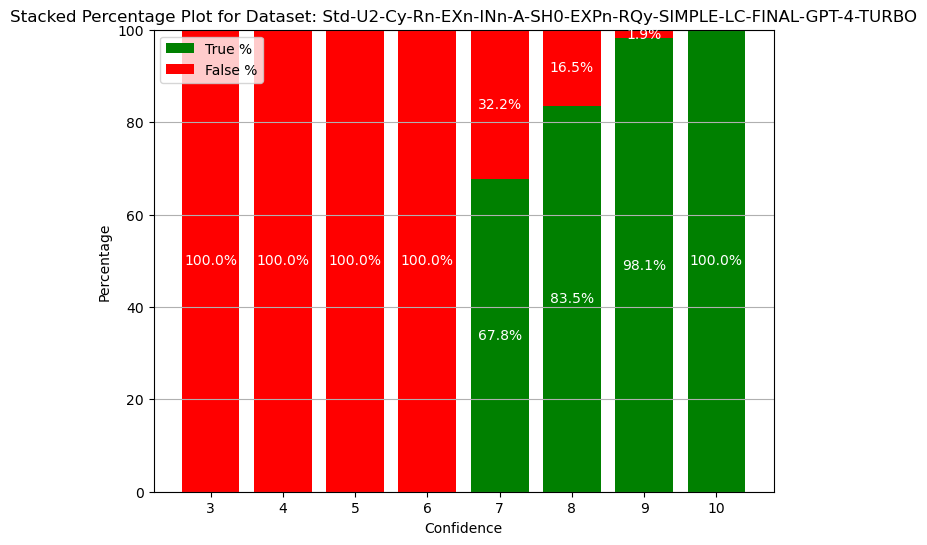

Confidence	True %	False %
3.0	0.0	100.0
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	67.8	32.2
8.0	83.5	16.5
9.0	98.1	1.9
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO


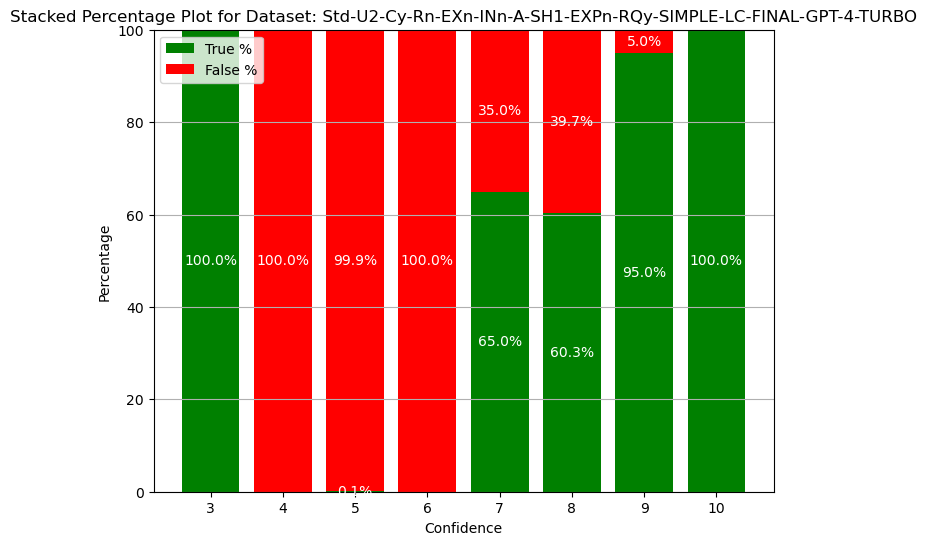

Confidence	True %	False %
3.0	100.0	0.0
4.0	0.0	100.0
5.0	0.1	99.9
6.0	0.0	100.0
7.0	65.0	35.0
8.0	60.3	39.7
9.0	95.0	5.0
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-LC-FINAL-GPT-4-TURBO


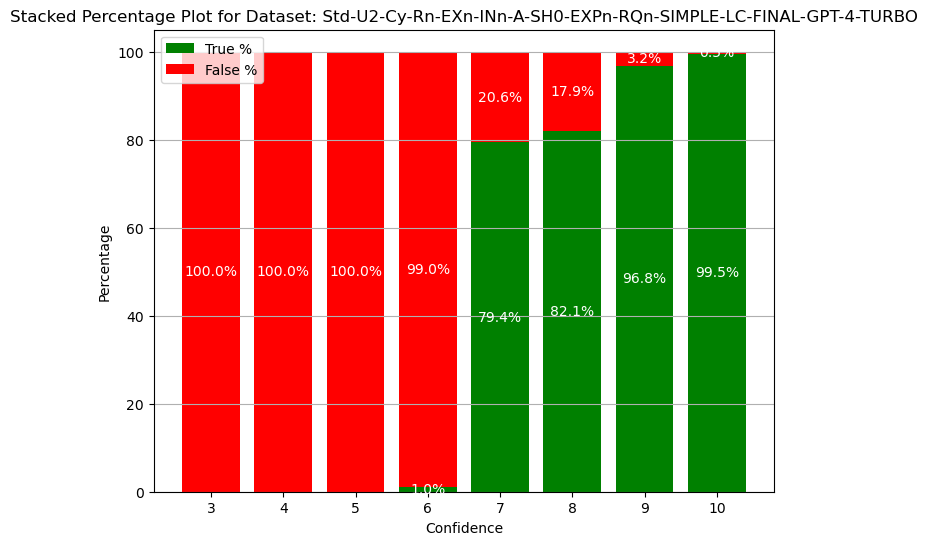

Confidence	True %	False %
3.0	0.0	100.0
4.0	0.0	100.0
5.0	0.0	100.0
6.0	1.0	99.0
7.0	79.4	20.6
8.0	82.1	17.9
9.0	96.8	3.2
10.0	99.5	0.5
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-LC-FINAL-GPT-4-TURBO


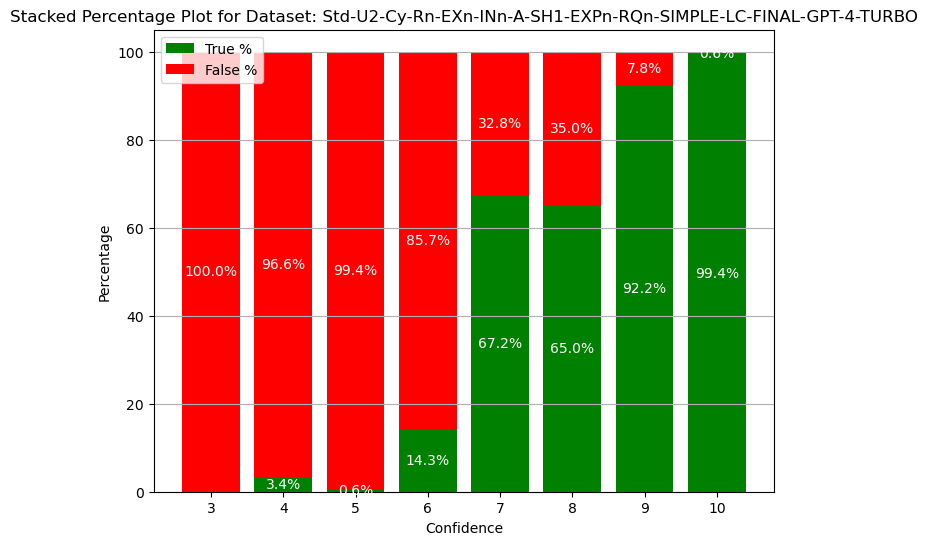

Confidence	True %	False %
3.0	0.0	100.0
4.0	3.4	96.6
5.0	0.6	99.4
6.0	14.3	85.7
7.0	67.2	32.8
8.0	65.0	35.0
9.0	92.2	7.8
10.0	99.4	0.6
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO


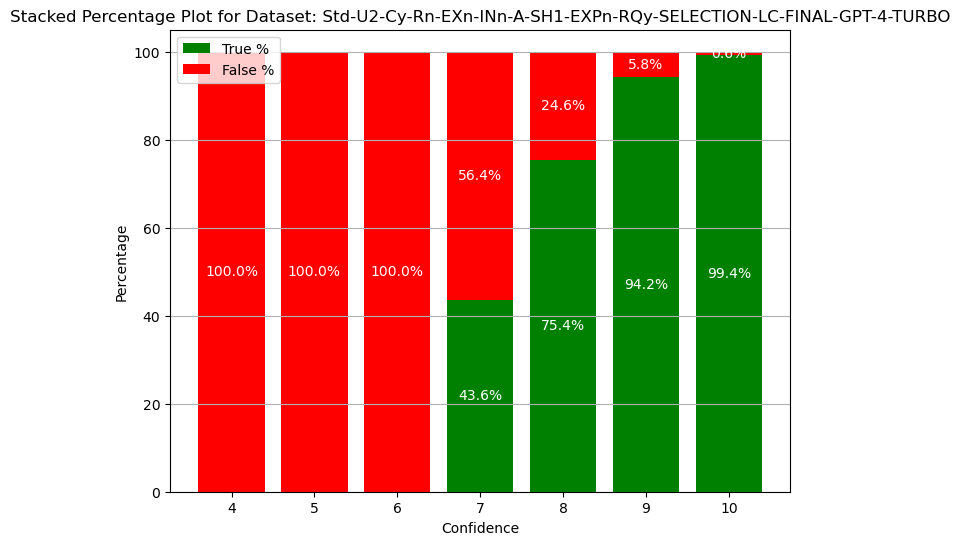

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	43.6	56.4
8.0	75.4	24.6
9.0	94.2	5.8
10.0	99.4	0.6
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO


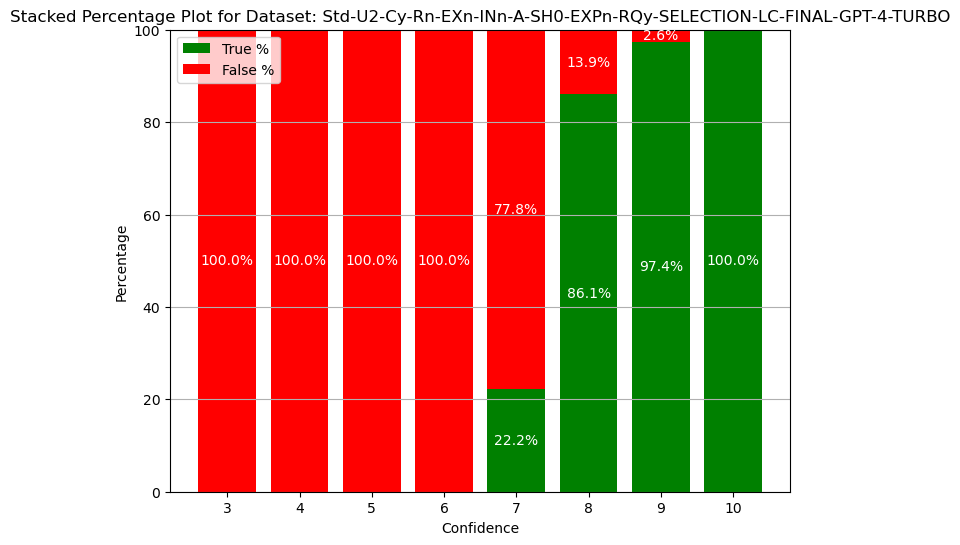

Confidence	True %	False %
3.0	0.0	100.0
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	22.2	77.8
8.0	86.1	13.9
9.0	97.4	2.6
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-LC-FINAL-GPT-4-TURBO


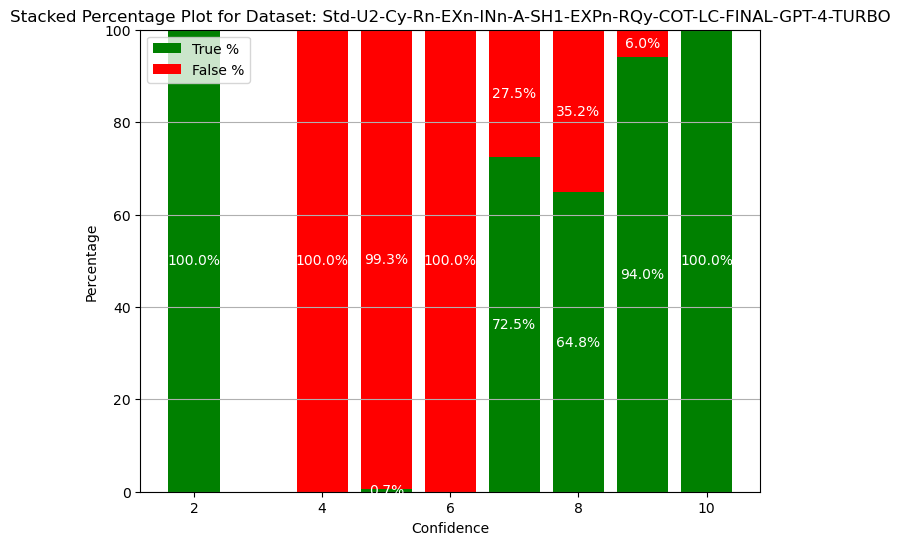

Confidence	True %	False %
2.0	100.0	0.0
4.0	0.0	100.0
5.0	0.7	99.3
6.0	0.0	100.0
7.0	72.5	27.5
8.0	64.8	35.2
9.0	94.0	6.0
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-LC-FINAL-GPT-4-TURBO


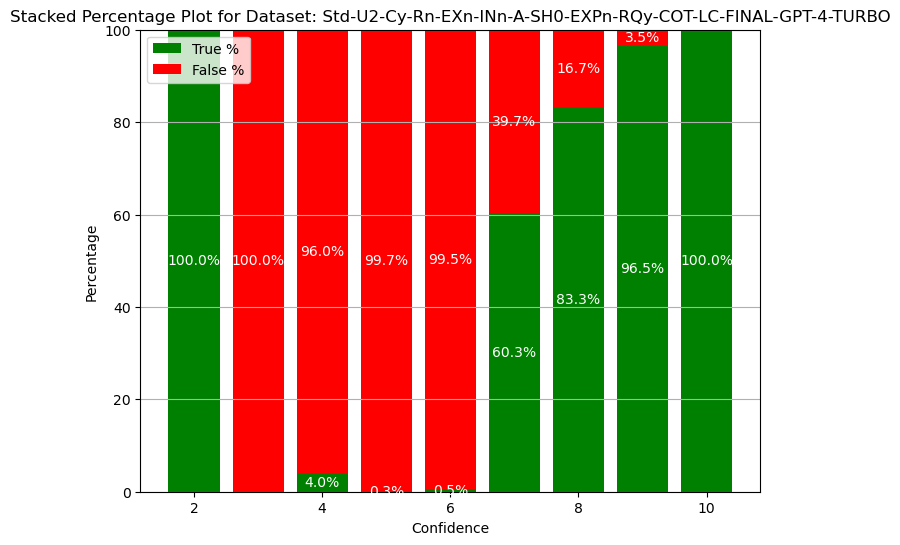

Confidence	True %	False %
2.0	100.0	0.0
3.0	0.0	100.0
4.0	4.0	96.0
5.0	0.3	99.7
6.0	0.5	99.5
7.0	60.3	39.7
8.0	83.3	16.7
9.0	96.5	3.5
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO


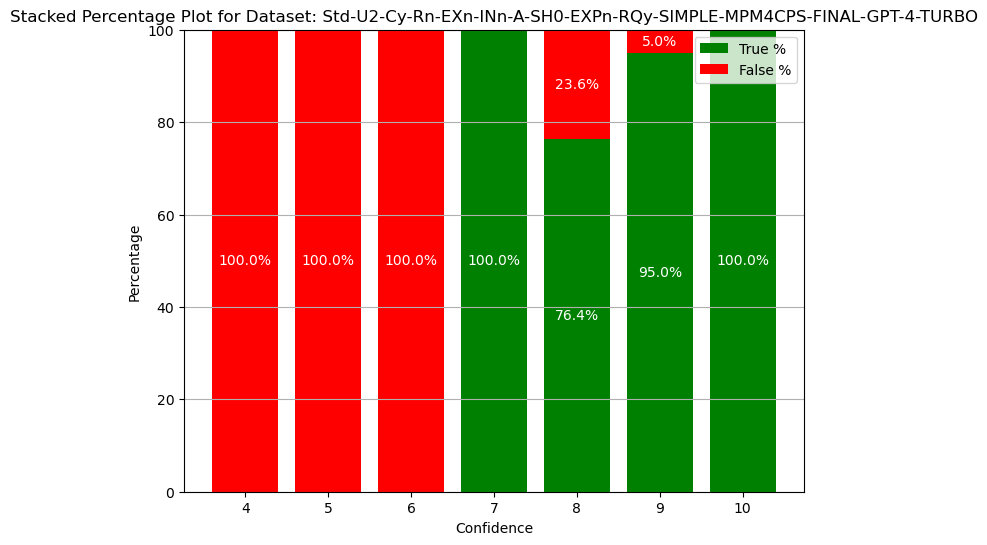

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	100.0	0.0
8.0	76.4	23.6
9.0	95.0	5.0
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO


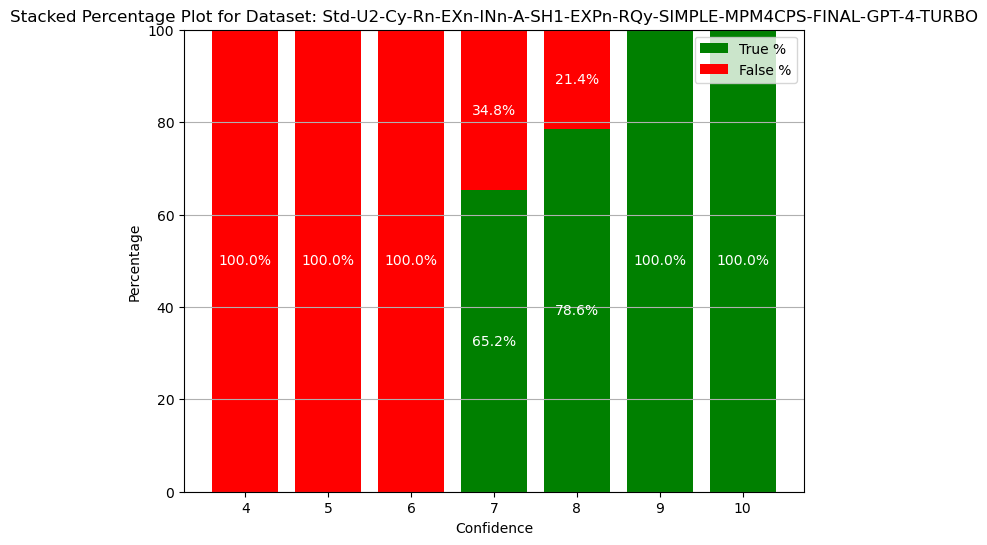

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	65.2	34.8
8.0	78.6	21.4
9.0	100.0	0.0
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO


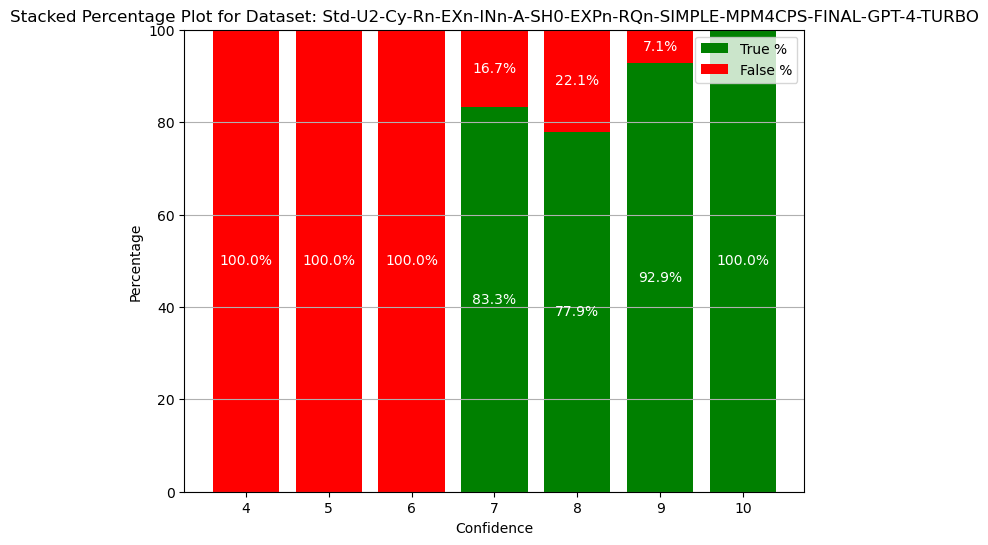

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	83.3	16.7
8.0	77.9	22.1
9.0	92.9	7.1
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO


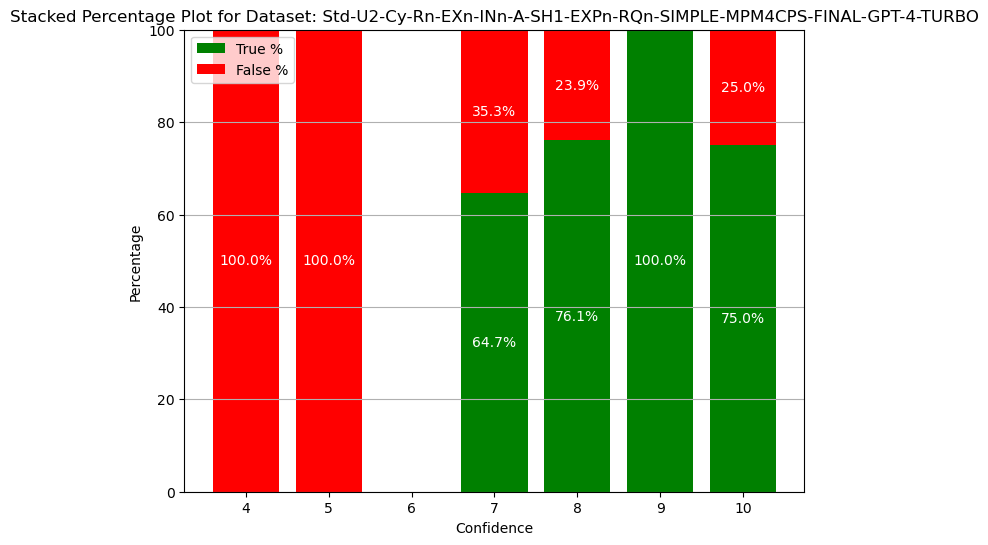

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
7.0	64.7	35.3
8.0	76.1	23.9
9.0	100.0	0.0
10.0	75.0	25.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-MPM4CPS-FINAL-GPT-4-TURBO


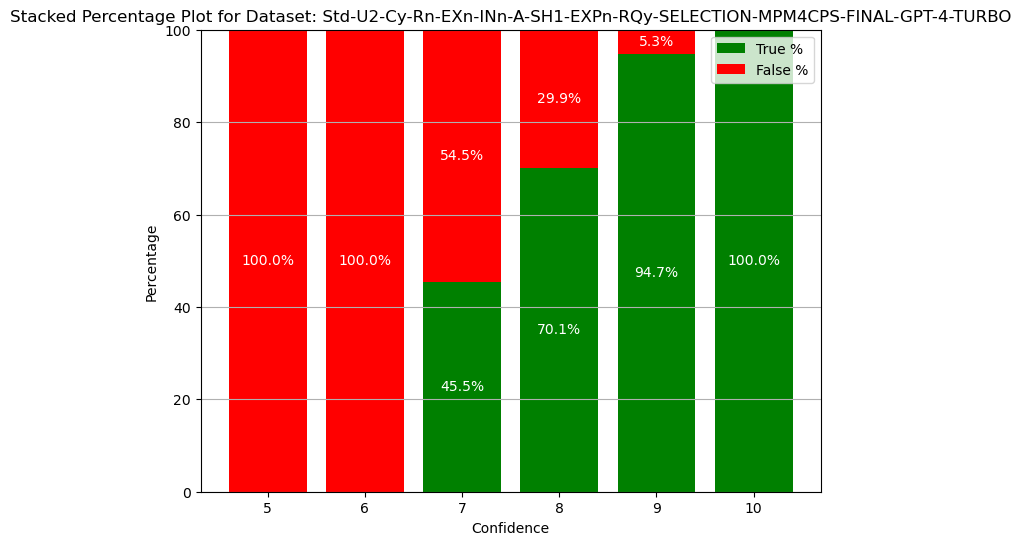

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	45.5	54.5
8.0	70.1	29.9
9.0	94.7	5.3
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-MPM4CPS-FINAL-GPT-4-TURBO


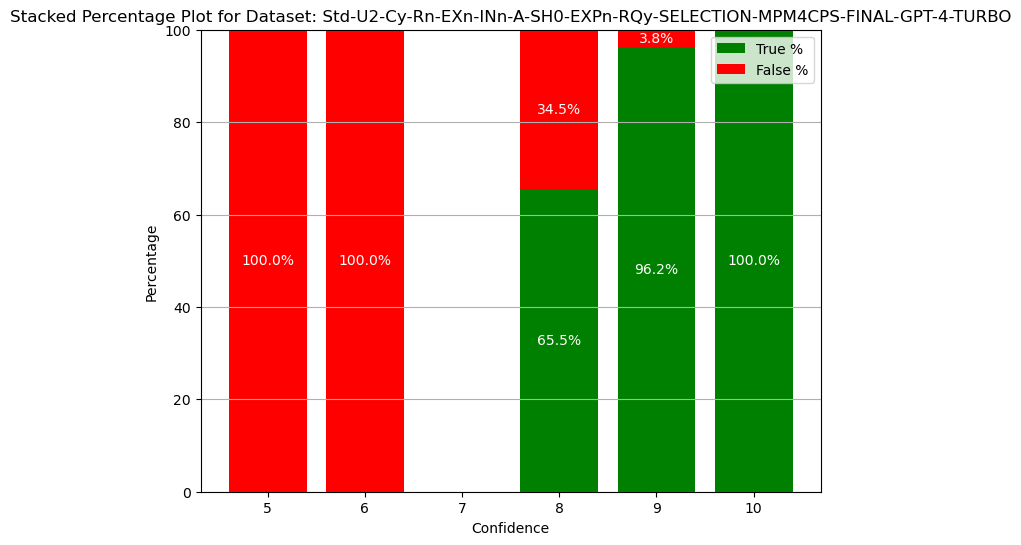

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
8.0	65.5	34.5
9.0	96.2	3.8
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-MPM4CPS-FINAL-GPT-4-TURBO


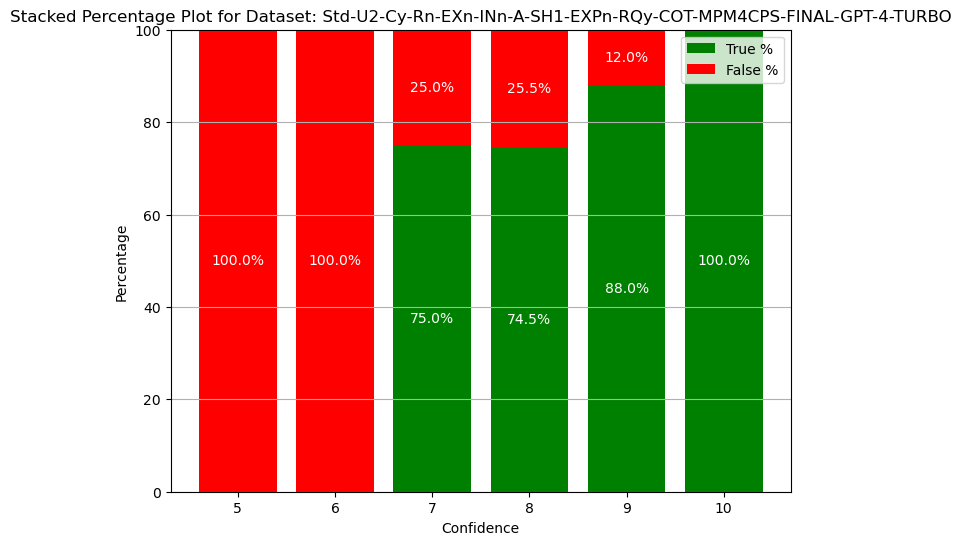

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	75.0	25.0
8.0	74.5	25.5
9.0	88.0	12.0
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-MPM4CPS-FINAL-GPT-4-TURBO


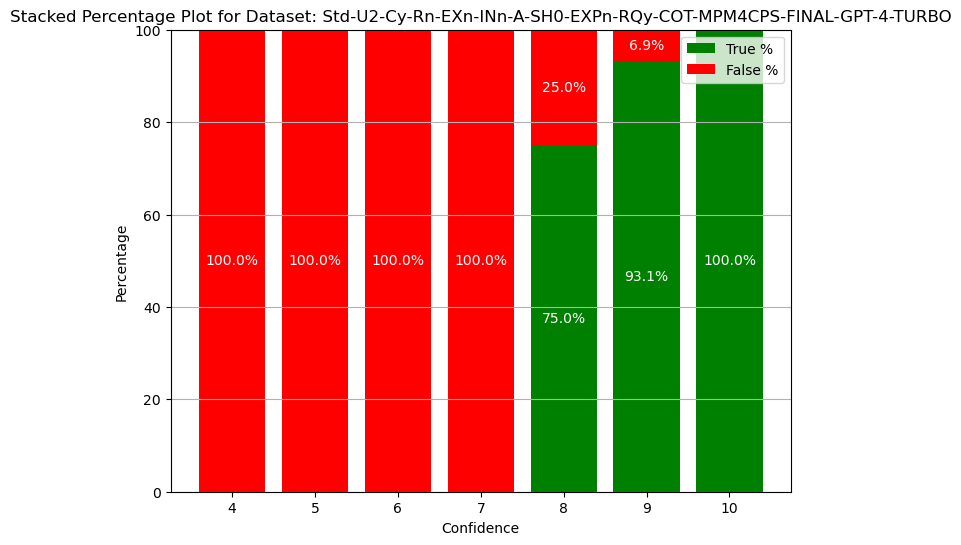

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	0.0	100.0
8.0	75.0	25.0
9.0	93.1	6.9
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO


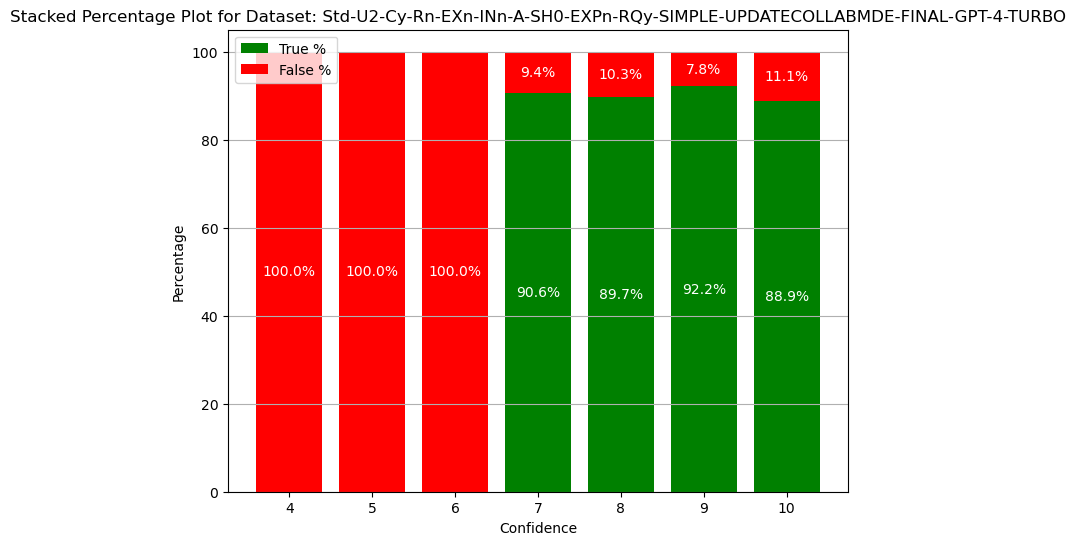

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	90.6	9.4
8.0	89.7	10.3
9.0	92.2	7.8
10.0	88.9	11.1
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO


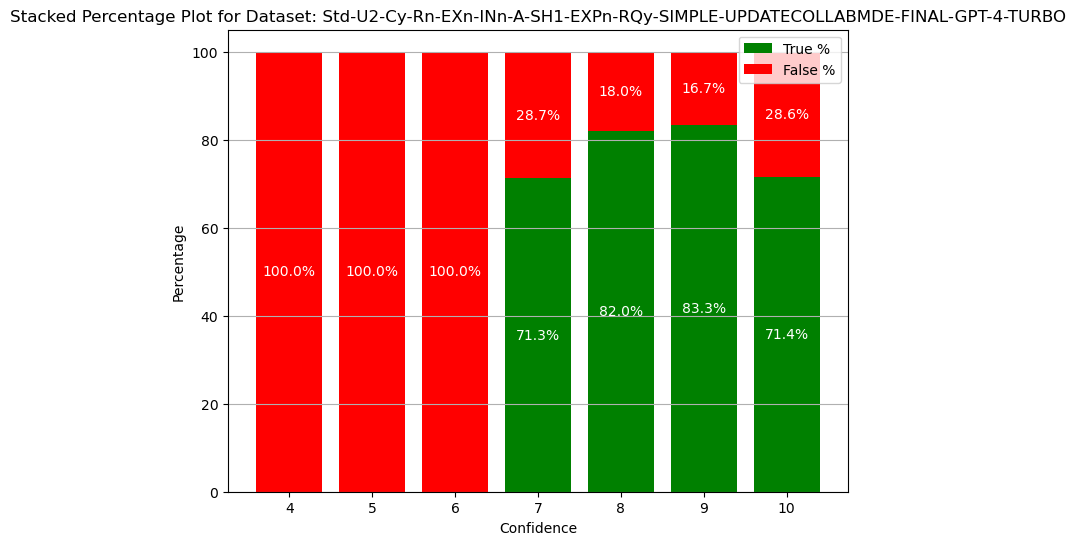

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	71.3	28.7
8.0	82.0	18.0
9.0	83.3	16.7
10.0	71.4	28.6
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO


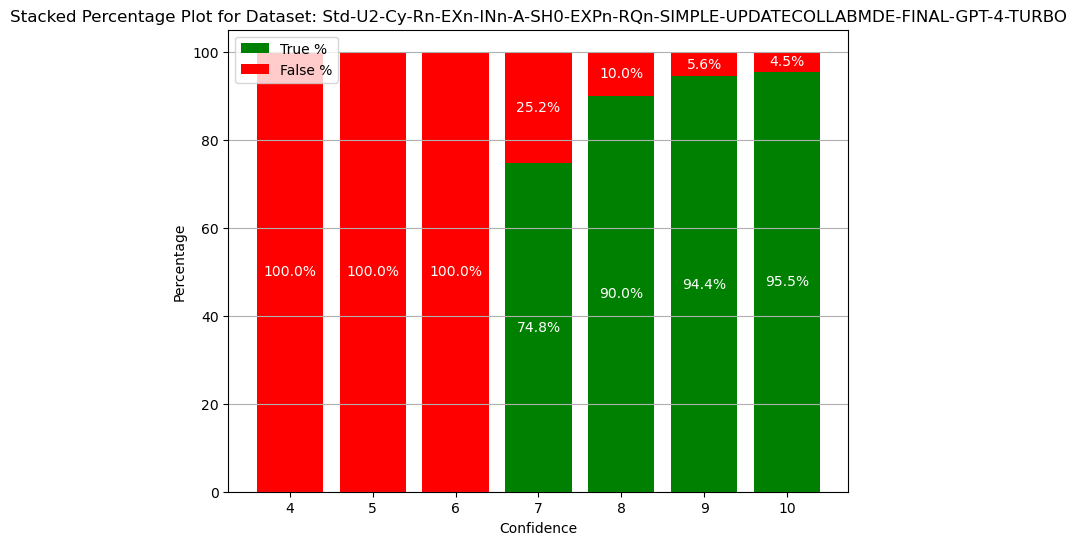

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	74.8	25.2
8.0	90.0	10.0
9.0	94.4	5.6
10.0	95.5	4.5
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO


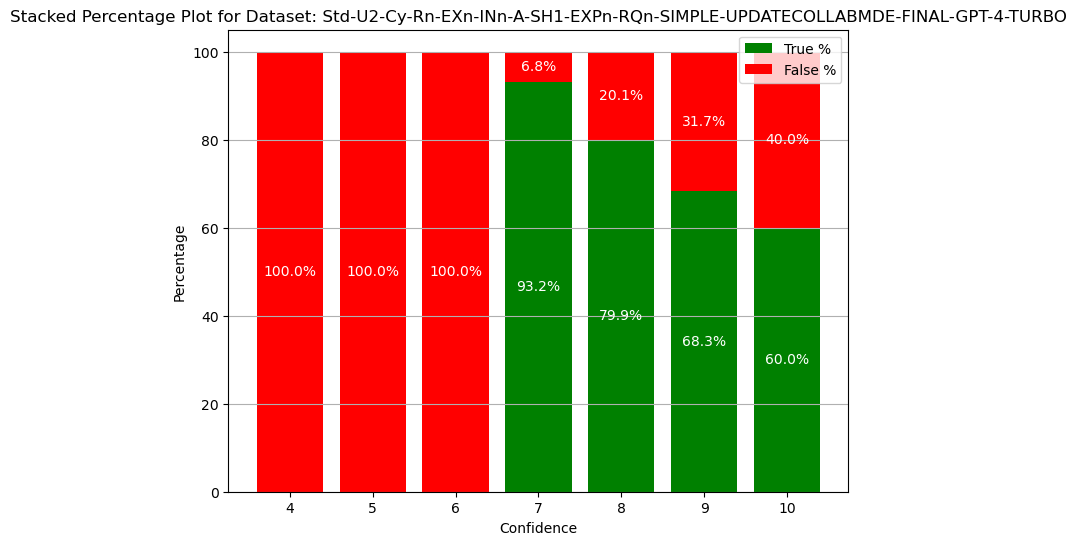

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	93.2	6.8
8.0	79.9	20.1
9.0	68.3	31.7
10.0	60.0	40.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-UPDATECOLLABMDE-FINAL-GPT-4-TURBO


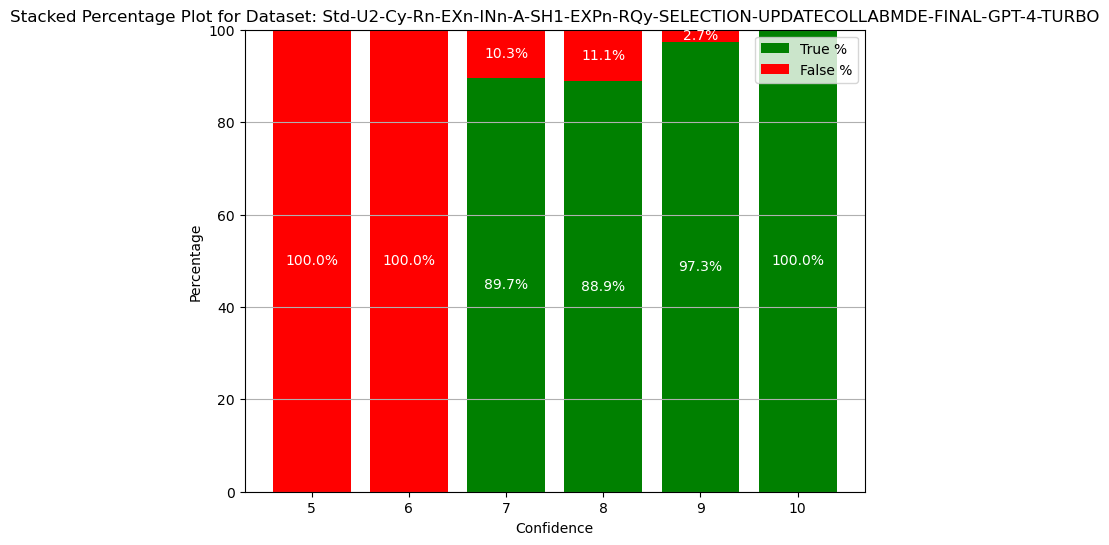

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	89.7	10.3
8.0	88.9	11.1
9.0	97.3	2.7
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-UPDATECOLLABMDE-FINAL-GPT-4-TURBO


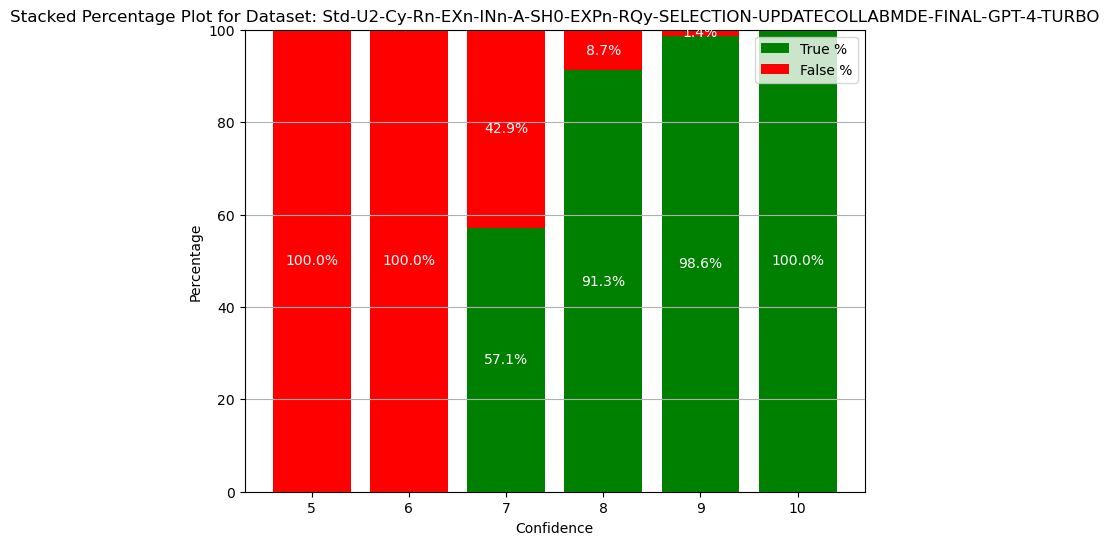

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	57.1	42.9
8.0	91.3	8.7
9.0	98.6	1.4
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-UPDATECOLLABMDE-FINAL-GPT-4-TURBO


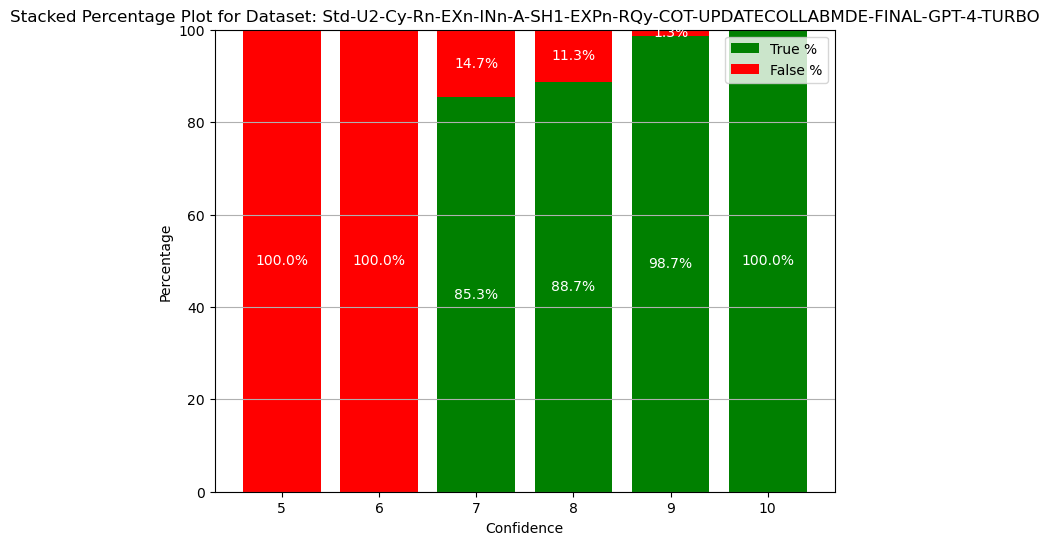

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	85.3	14.7
8.0	88.7	11.3
9.0	98.7	1.3
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-UPDATECOLLABMDE-FINAL-GPT-4-TURBO


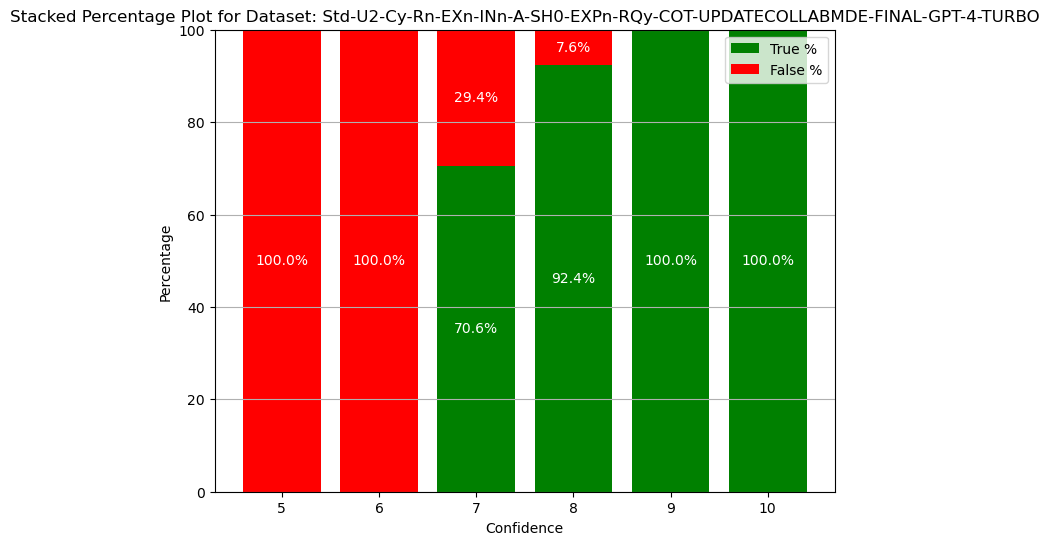

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	70.6	29.4
8.0	92.4	7.6
9.0	100.0	0.0
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-GAMESEFINAL-FINAL-GPT-4-TURBO


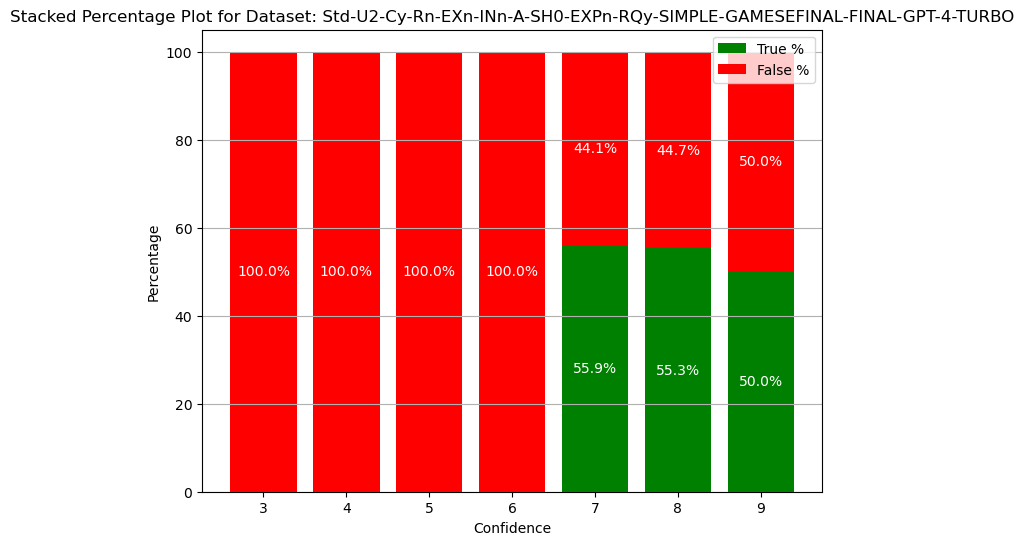

Confidence	True %	False %
3.0	0.0	100.0
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	55.9	44.1
8.0	55.3	44.7
9.0	50.0	50.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-GAMESEFINAL-FINAL-GPT-4-TURBO


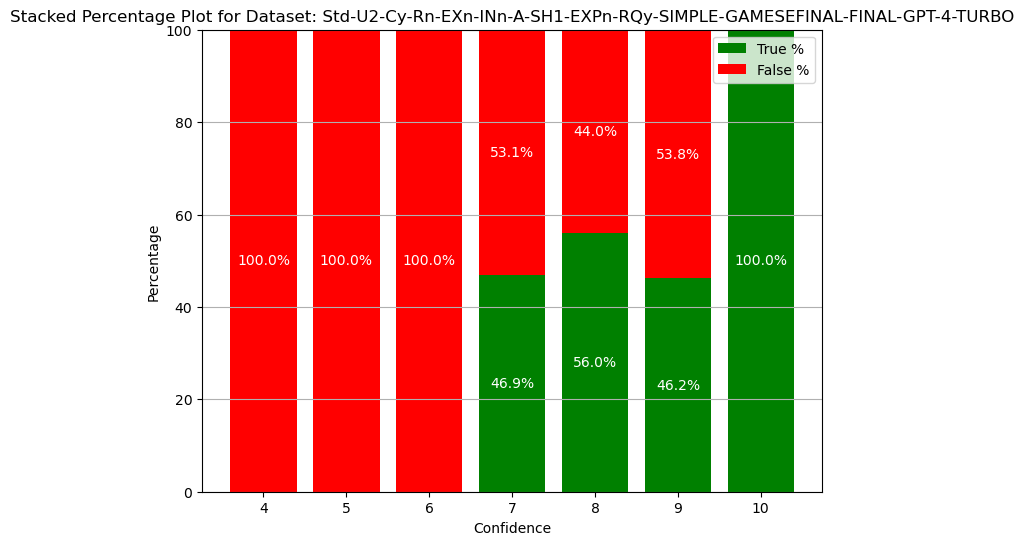

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	46.9	53.1
8.0	56.0	44.0
9.0	46.2	53.8
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-GAMESEFINAL-FINAL-GPT-4-TURBO


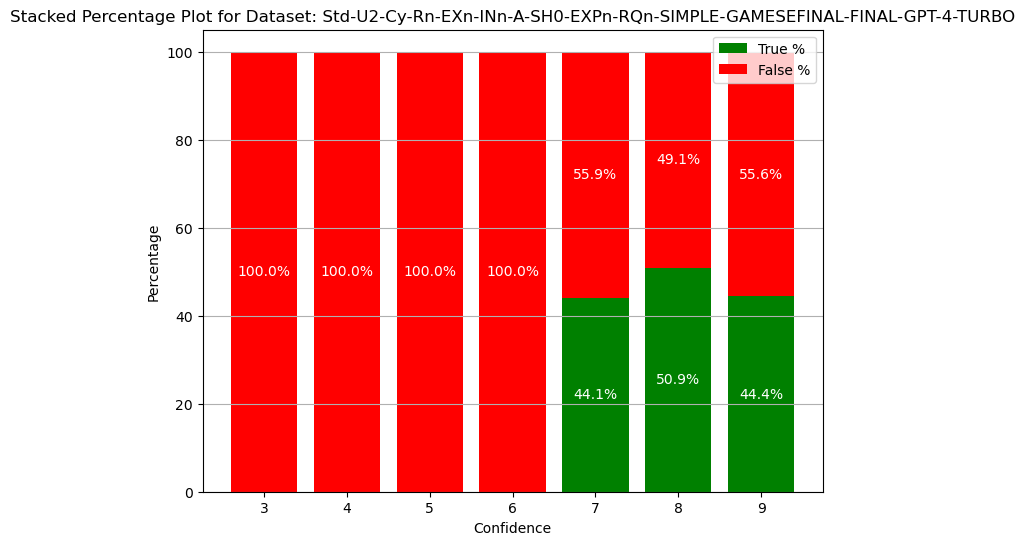

Confidence	True %	False %
3.0	0.0	100.0
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	44.1	55.9
8.0	50.9	49.1
9.0	44.4	55.6
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-GAMESEFINAL-FINAL-GPT-4-TURBO


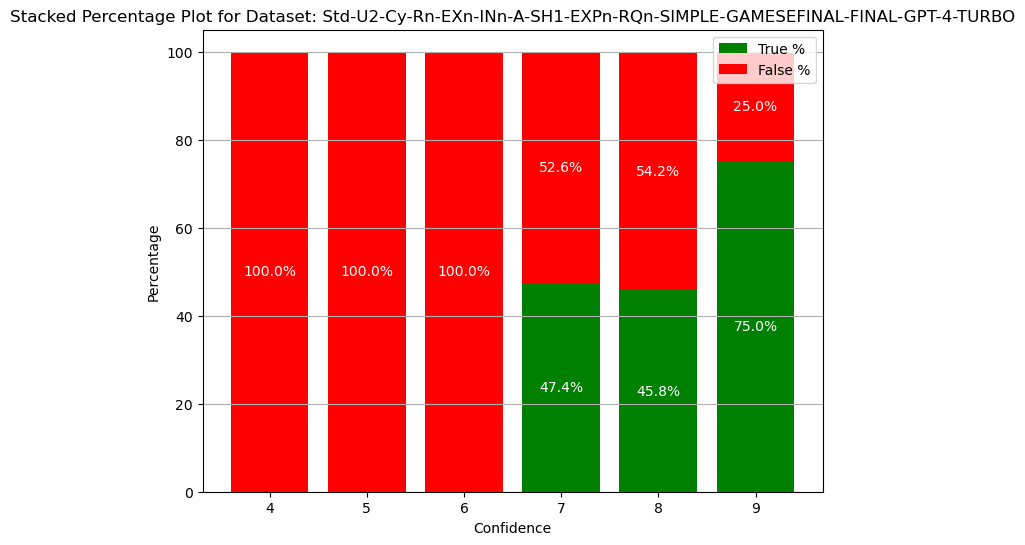

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	47.4	52.6
8.0	45.8	54.2
9.0	75.0	25.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-GAMESEFINAL-FINAL-GPT-4-TURBO


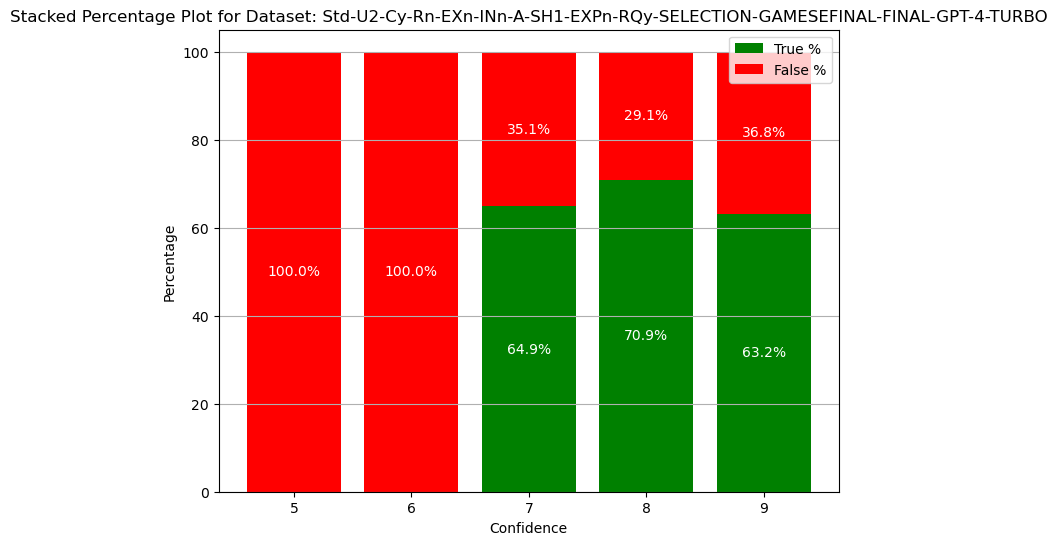

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	64.9	35.1
8.0	70.9	29.1
9.0	63.2	36.8
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-GAMESEFINAL-FINAL-GPT-4-TURBO


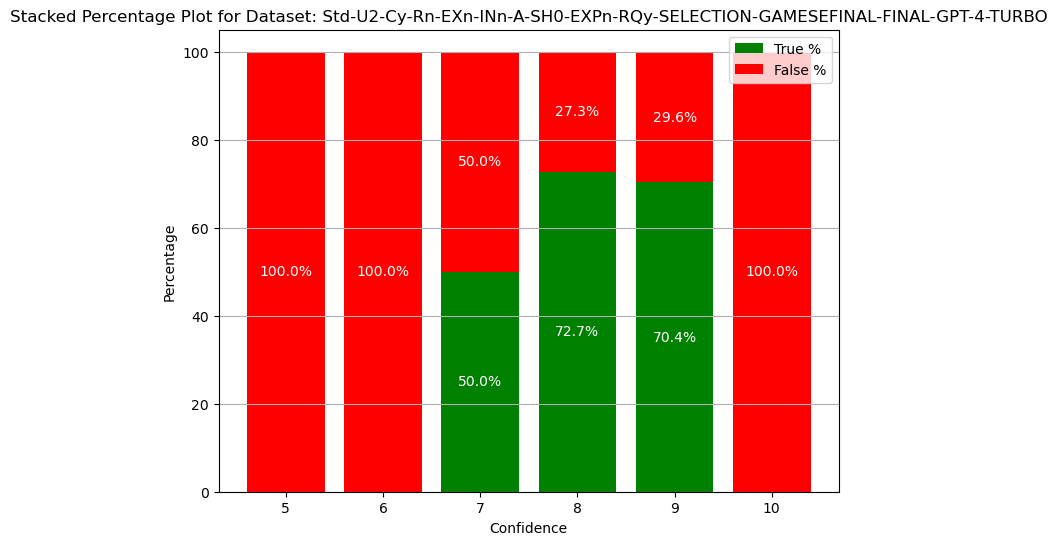

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	50.0	50.0
8.0	72.7	27.3
9.0	70.4	29.6
10.0	0.0	100.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-GAMESEFINAL-FINAL-GPT-4-TURBO


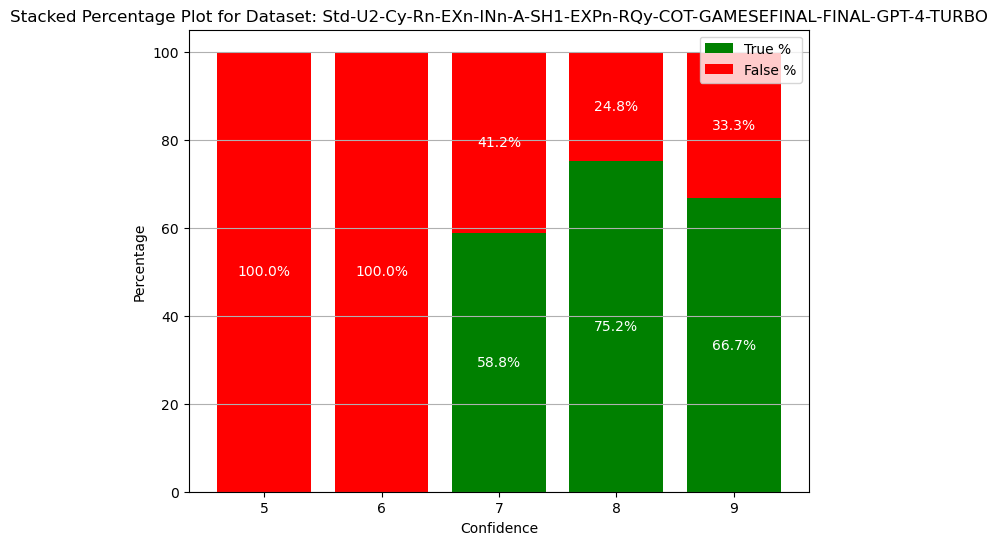

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	58.8	41.2
8.0	75.2	24.8
9.0	66.7	33.3
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-GAMESEFINAL-FINAL-GPT-4-TURBO


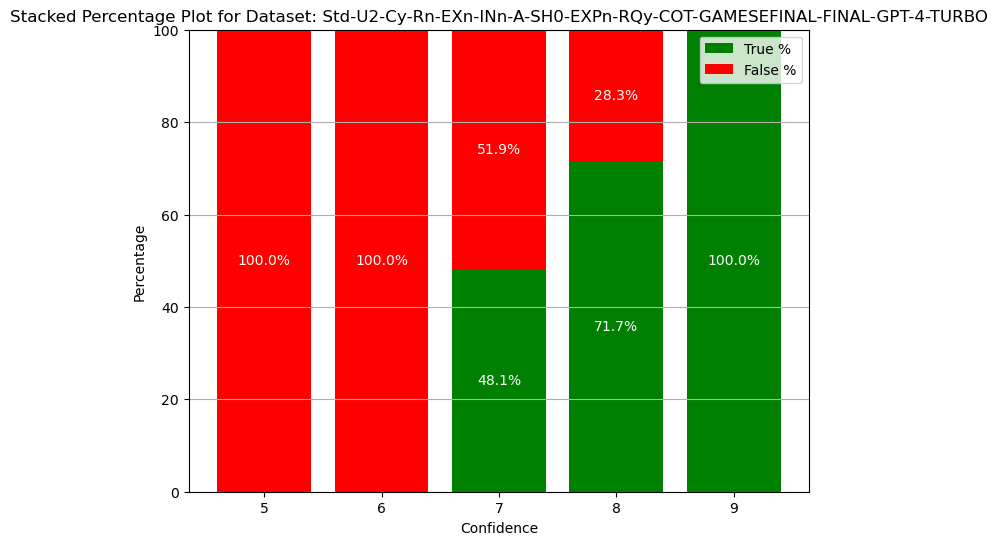

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	48.1	51.9
8.0	71.7	28.3
9.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-ESM2-FINAL-GPT-4-TURBO


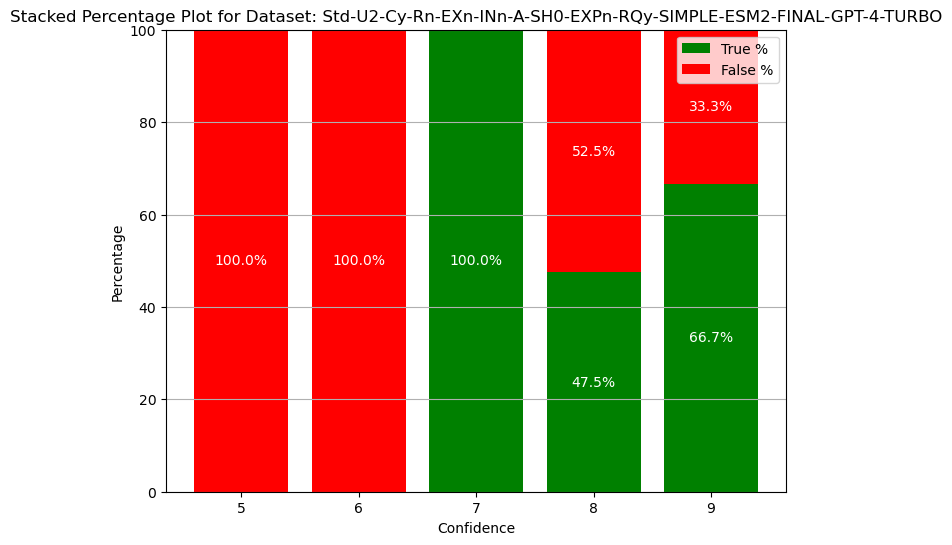

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	100.0	0.0
8.0	47.5	52.5
9.0	66.7	33.3
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-ESM2-FINAL-GPT-4-TURBO


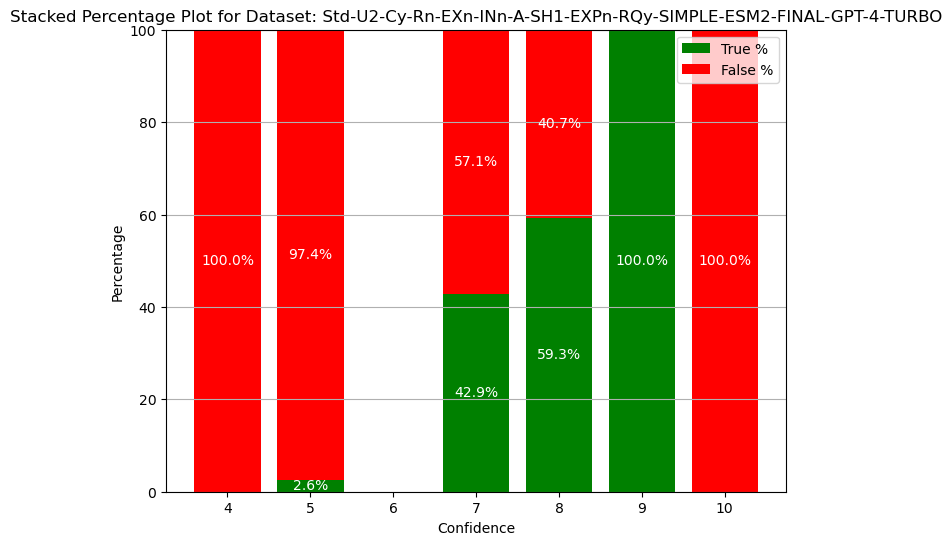

Confidence	True %	False %
4.0	0.0	100.0
5.0	2.6	97.4
7.0	42.9	57.1
8.0	59.3	40.7
9.0	100.0	0.0
10.0	0.0	100.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-ESM2-FINAL-GPT-4-TURBO


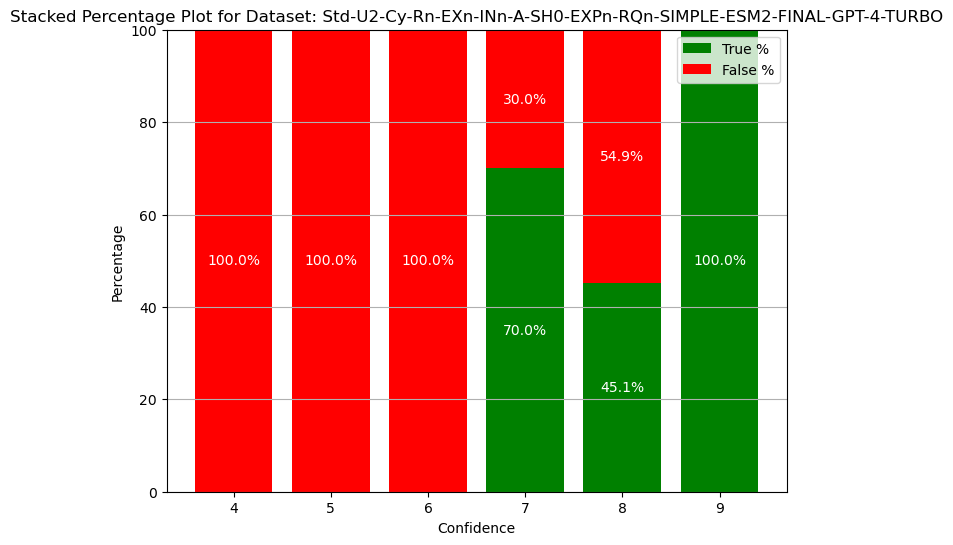

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	70.0	30.0
8.0	45.1	54.9
9.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-ESM2-FINAL-GPT-4-TURBO


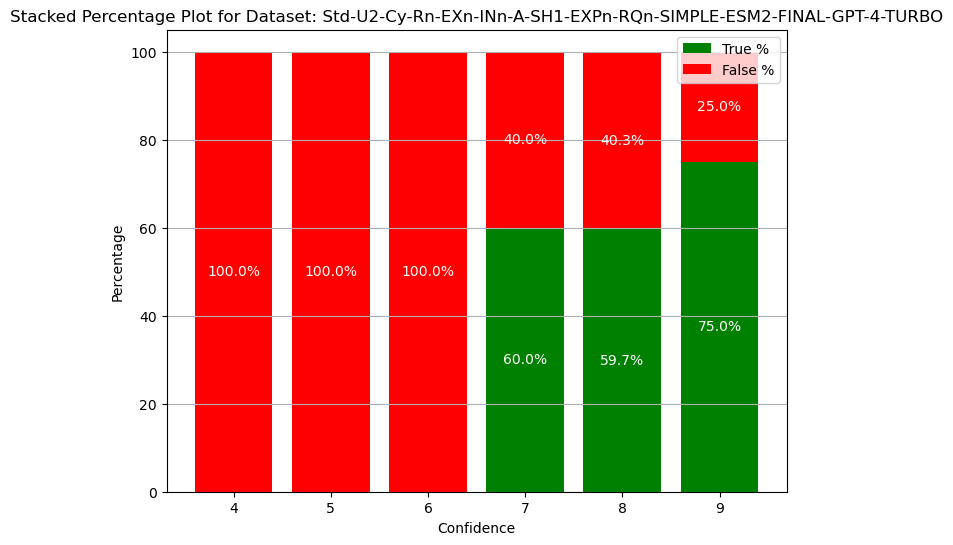

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	60.0	40.0
8.0	59.7	40.3
9.0	75.0	25.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-ESM2-FINAL-GPT-4-TURBO


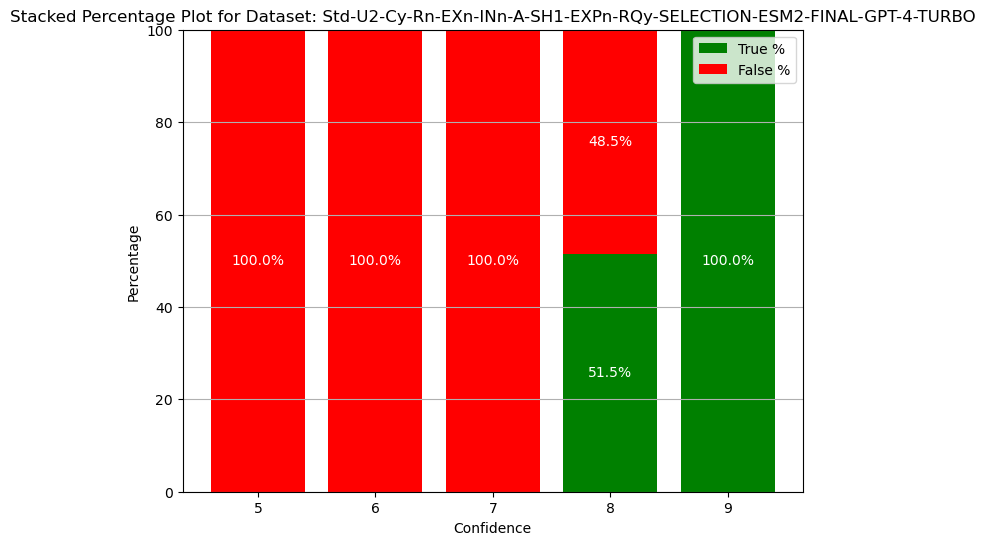

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	0.0	100.0
8.0	51.5	48.5
9.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-ESM2-FINAL-GPT-4-TURBO


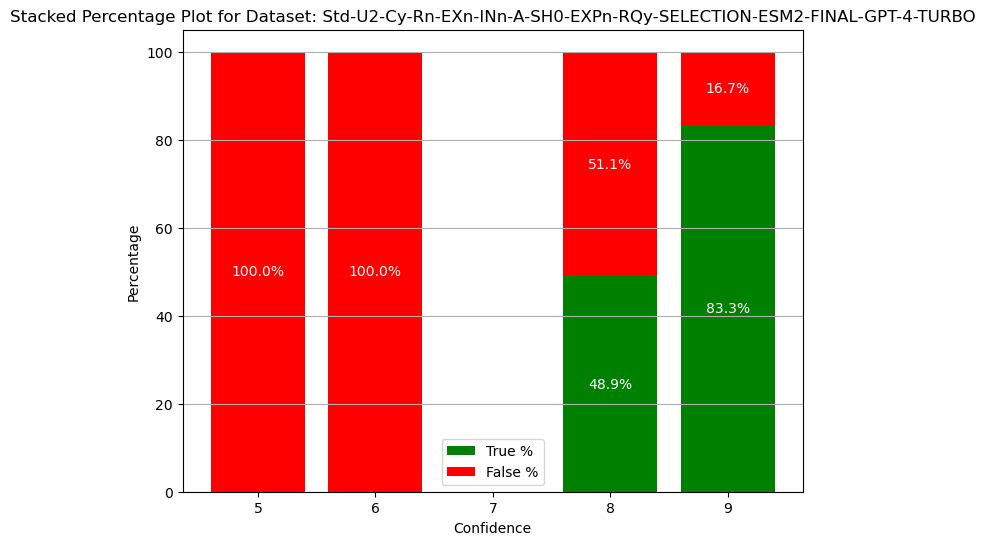

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
8.0	48.9	51.1
9.0	83.3	16.7
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-ESM2-FINAL-GPT-4-TURBO


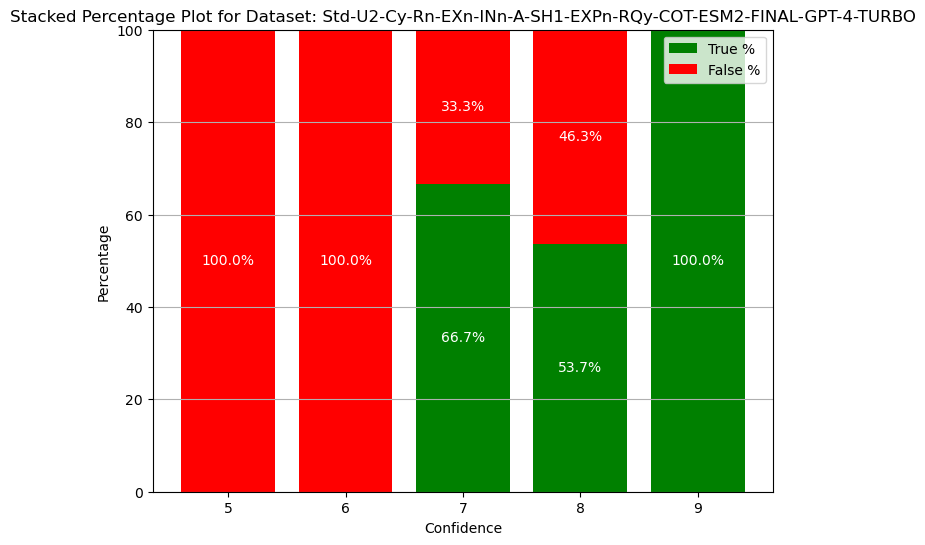

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	66.7	33.3
8.0	53.7	46.3
9.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-ESM2-FINAL-GPT-4-TURBO


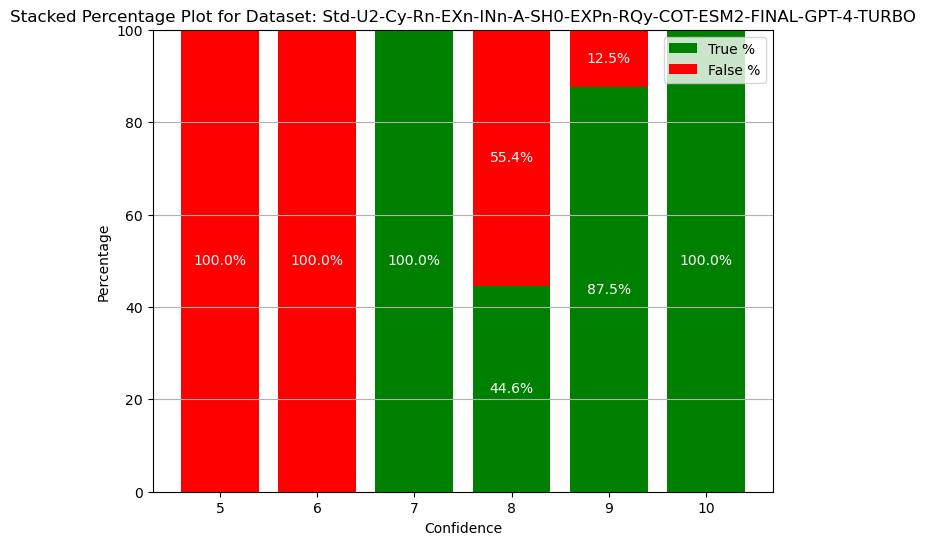

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	100.0	0.0
8.0	44.6	55.4
9.0	87.5	12.5
10.0	100.0	0.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-TESTNN-FINAL-GPT-4-TURBO


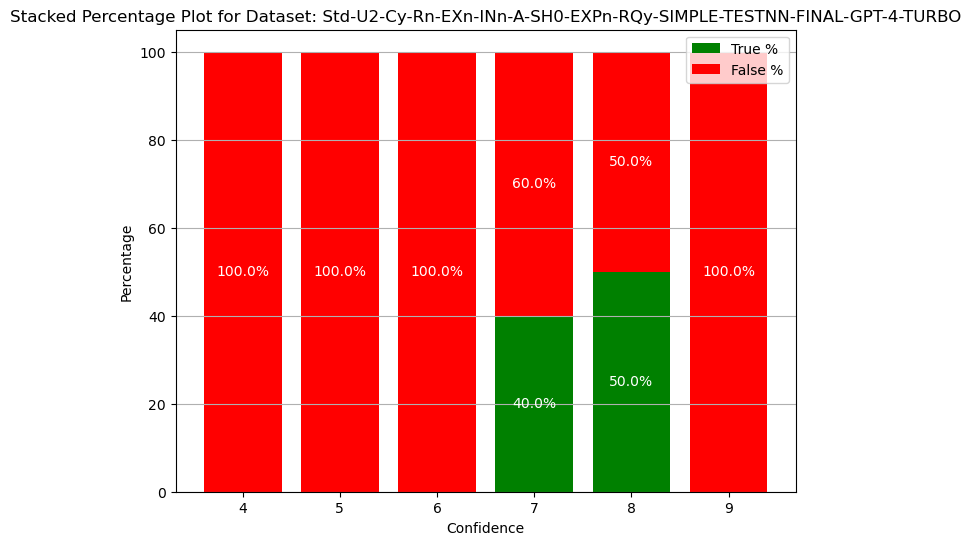

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	40.0	60.0
8.0	50.0	50.0
9.0	0.0	100.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-TESTNN-FINAL-GPT-4-TURBO


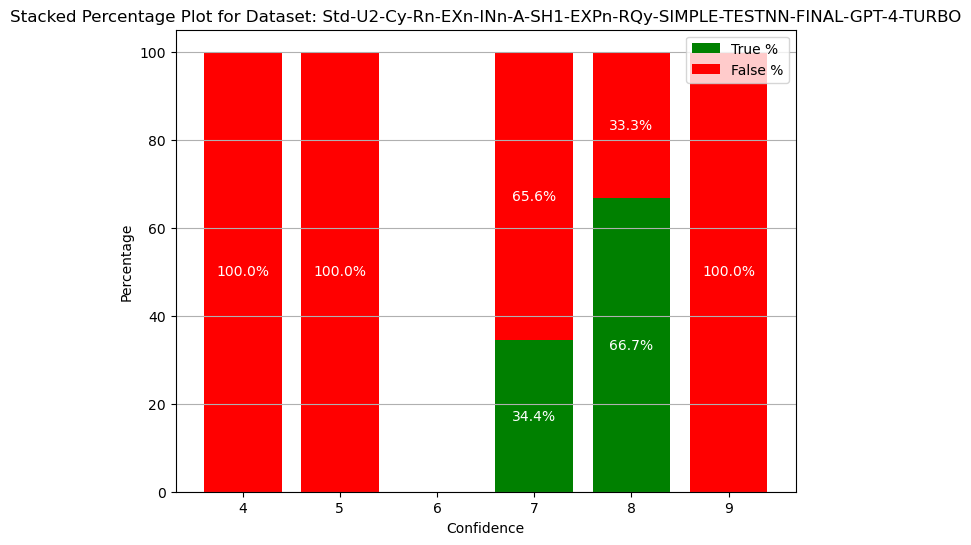

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
7.0	34.4	65.6
8.0	66.7	33.3
9.0	0.0	100.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-TESTNN-FINAL-GPT-4-TURBO


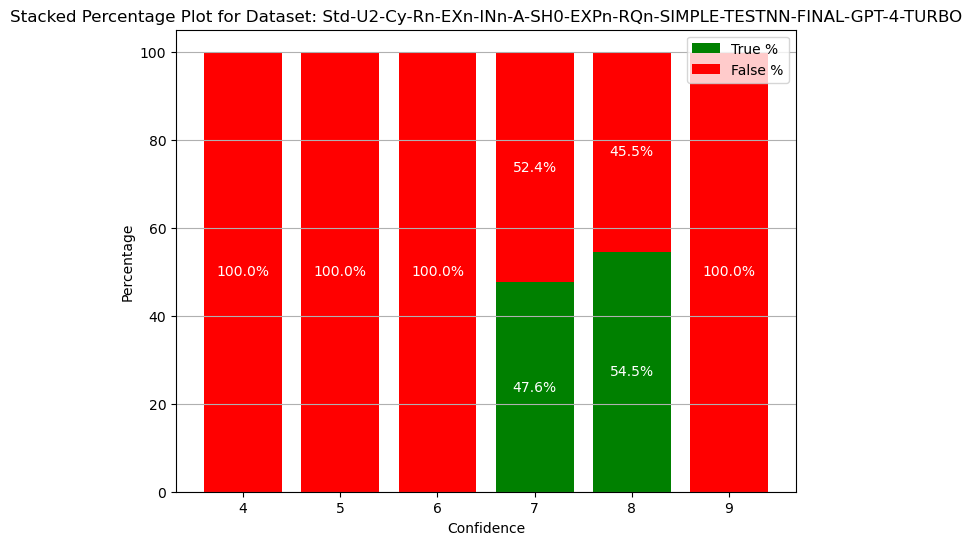

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	47.6	52.4
8.0	54.5	45.5
9.0	0.0	100.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-TESTNN-FINAL-GPT-4-TURBO


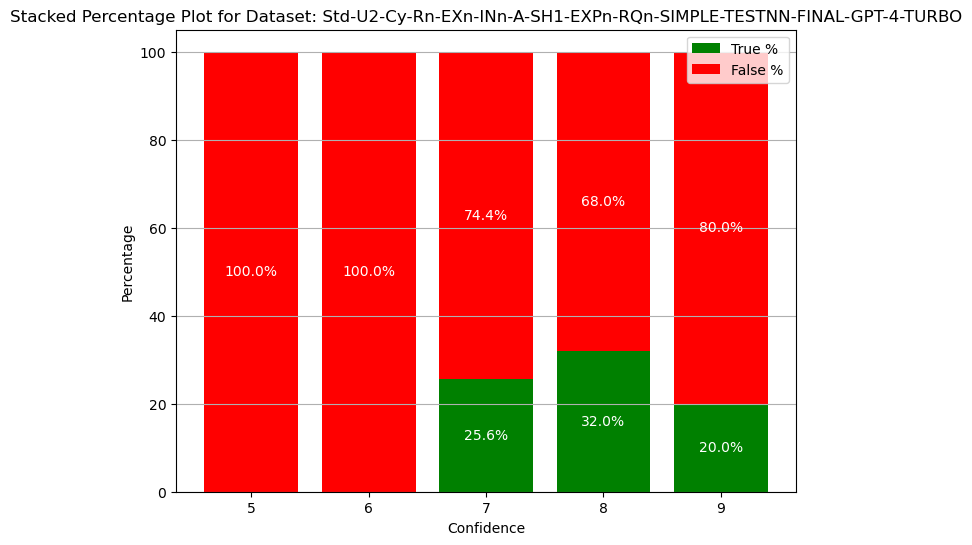

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	25.6	74.4
8.0	32.0	68.0
9.0	20.0	80.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-TESTNN-FINAL-GPT-4-TURBO


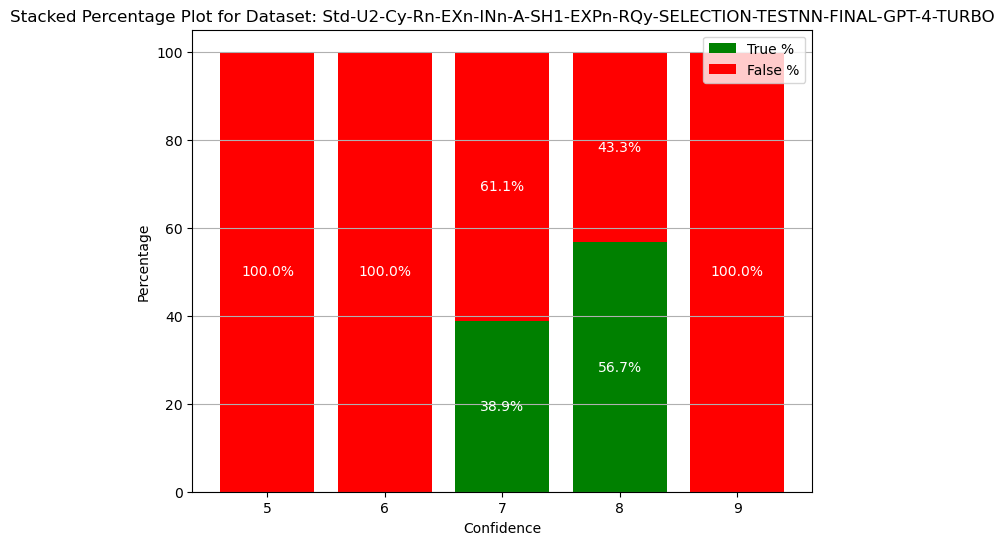

Confidence	True %	False %
5.0	0.0	100.0
6.0	0.0	100.0
7.0	38.9	61.1
8.0	56.7	43.3
9.0	0.0	100.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-TESTNN-FINAL-GPT-4-TURBO


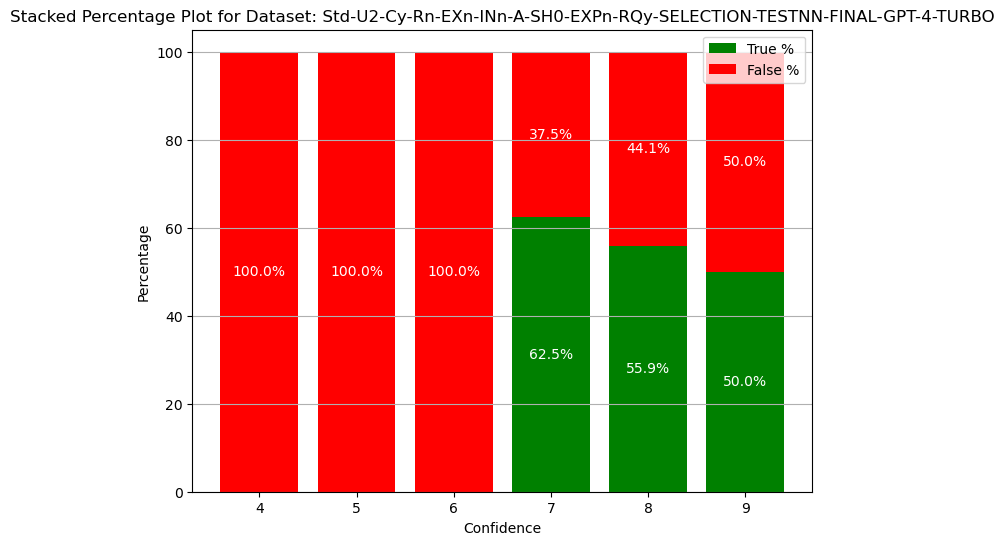

Confidence	True %	False %
4.0	0.0	100.0
5.0	0.0	100.0
6.0	0.0	100.0
7.0	62.5	37.5
8.0	55.9	44.1
9.0	50.0	50.0
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-TESTNN-FINAL-GPT-4-TURBO


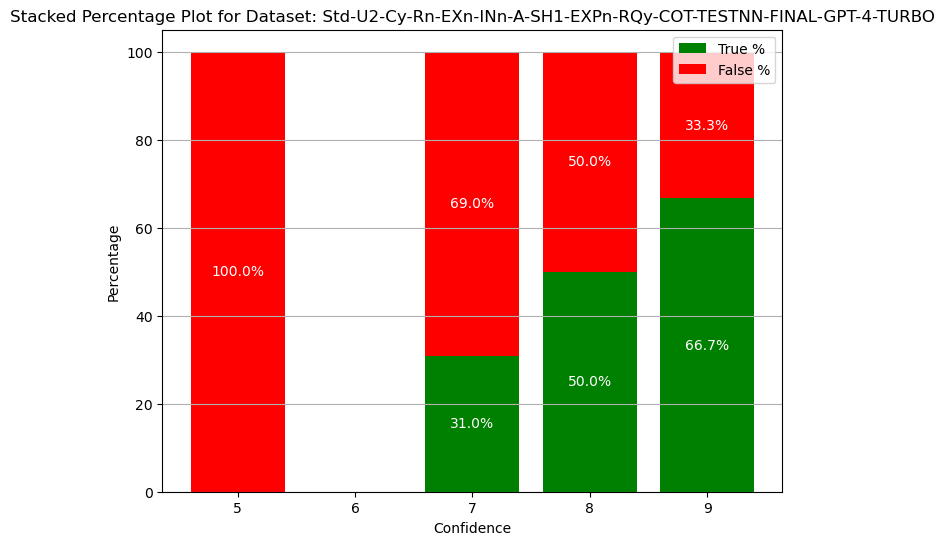

Confidence	True %	False %
5.0	0.0	100.0
7.0	31.0	69.0
8.0	50.0	50.0
9.0	66.7	33.3
--------------------------------------------------
Dataset: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-TESTNN-FINAL-GPT-4-TURBO


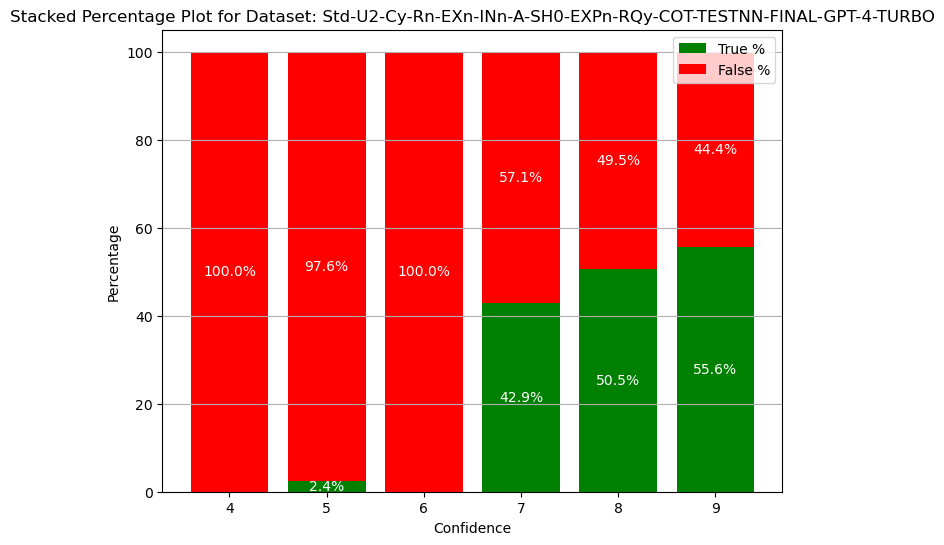

Confidence	True %	False %
4.0	0.0	100.0
5.0	2.4	97.6
6.0	0.0	100.0
7.0	42.9	57.1
8.0	50.5	49.5
9.0	55.6	44.4
--------------------------------------------------


In [ ]:
# for n, df in dfs.items():
#     print(n)
#     # Check the current distribution of 'is_true'
#     df.groupby('Confidence')['is_true'].value_counts()

#     # Ensure 'is_true' is binary (0 or 1)
#     df['is_true'] = df['is_true'].apply(lambda x: 1 if x else 0)

#     # Group by 'Confidence' and 'is_true', and count occurrences
#     grouped = df_for_manwhitney.groupby(['Confidence', 'is_true']).size().unstack(fill_value=0)

#     # Rename columns for clarity
#     grouped.columns = ['False', 'True']

#     # Rearrange the columns and reset the index
#     grouped = grouped[['True', 'False']].reset_index()

#     # Display the resulting DataFrame
#     print(grouped.to_string(index=False))

# for n, df in dfs.items():
#     print("Dataset:", n)
    
#     # Ensure 'is_true' is binary (0 or 1)
#     df['is_true'] = df['is_true'].apply(lambda x: 1 if x else 0)
    
#     # Group by 'Confidence' and 'is_true', and count occurrences
#     grouped = df.groupby(['Confidence', 'is_true']).size().unstack(fill_value=0)
    
#     # Rename columns for clarity
#     grouped.columns = ['false', 'true']
    
#     # Rearrange the columns and reset the index
#     grouped = grouped[['true', 'false']].reset_index()

#     # Prepare output in tab-separated format (Excel-compatible)
#     print("Confidence\tTrue\tFalse")  # Print headers
#     for row in grouped.itertuples(index=False):
#         print("{}\t{}\t{}".format(row.Confidence, row.true, row.false))
    
#     print("-" * 50)  # Separator for readability
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

for n, df in dfs_new.items():
    print("Dataset:", n)
    df['is_true'] = df['is_true'].apply(lambda x: 1 if x else 0)
    
    # Group by 'Confidence' and 'is_true', and count occurrences
    grouped = df.groupby(['Confidence', 'is_true']).size().unstack(fill_value=0)
    
    # Rename columns for clarity
    grouped.columns = ['false', 'true']
    
    # Rearrange the columns and reset the index
    grouped = grouped[['true', 'false']].reset_index()

    df = grouped.copy()
    # Normalize to get percentages
    df['Total'] = df['true'] + df['false']
    df['True_pct'] = df['true'] / df['Total'] * 100
    df['False_pct'] = df['false'] / df['Total'] * 100

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Stacked Bar Plot
    ax.bar(df['Confidence'], df['True_pct'], label='True %', color='green')
    ax.bar(df['Confidence'], df['False_pct'], bottom=df['True_pct'], label='False %', color='red')

    # Add text annotations for values
    for i, (conf, true_val, false_val) in enumerate(zip(df['Confidence'], df['True_pct'], df['False_pct'])):
        if true_val > 0:
            ax.text(conf, true_val / 2, f"{true_val:.1f}%", ha='center', va='center', color='white')
        if false_val > 0:
            ax.text(conf, true_val + false_val / 2, f"{false_val:.1f}%", ha='center', va='center', color='white')

    # Add labels and title
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Stacked Percentage Plot for Dataset: {n}')
    ax.legend()

    # Show grid for better readability
    ax.yaxis.grid(True)

    # Show the plot
    plt.show()

    print("Confidence\tTrue %\tFalse %")
    for row in df.itertuples(index=False):
        print(f"{row.Confidence}\t{row.True_pct:.1f}\t{row.False_pct:.1f}")
    print("-" * 50)


In [63]:
dfs_new

{'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO':                                 ArticleKey  Confidence  is_true
 0     10b8a793-5b5d-4b61-8412-3c7881d71bcc         8.0        1
 1     ab52616c-c867-46c2-a753-d0d054b03cc8         8.0        1
 2     9a50750e-d524-4039-99bc-92b42fbbd715         8.0        1
 3     34dd9ba5-b285-4b96-86eb-defc855648c3         8.0        1
 4     246baf8e-c7cf-436a-889c-0cb3f47d9da3         8.0        1
 ...                                    ...         ...      ...
 2678  2e276d91-0fd9-4f20-9817-5760daaf791d         5.0        0
 2679  3402f3a8-a3b1-4d6c-b4d6-5cb34bf1652f         8.0        0
 2680  76c69db6-9a29-4b3c-81de-83abb076bba9         8.0        1
 2681  b9ca09e6-5b0a-4c23-b7be-98c76c3fb53b         5.0        0
 2682  5cf1b0fd-1987-4bac-a0d8-5a50838799b8         8.0        0
 
 [2683 rows x 3 columns],
 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO':                                 ArticleKey  Confidence  i

In [ ]:
# Separate plots for each dataset, showing all experiments' data points
unique_datasets = set(key.split('-')[-5] for key in dfs_new.keys())

for dataset_name in unique_datasets:
    plt.figure(figsize=(10, 8))
    
    for key, df in dfs_new.items():
        if dataset_name in key:  # Match dataset name in key
            df['is_true'] = df['is_true'].apply(lambda x: 1 if x else 0)
            grouped = df.groupby(['Confidence', 'is_true']).size().unstack(fill_value=0)
            grouped.columns = ['false', 'true']
            grouped = grouped[['true', 'false']].reset_index()
            df_grouped = grouped.copy()
            df_grouped['Total'] = df_grouped['true'] + df_grouped['false']
            df_grouped['Sensitivity'] = df_grouped['true'] / (df_grouped['true'] + df_grouped['false'])
            df_grouped['Specificity'] = df_grouped['false'] / (df_grouped['true'] + df_grouped['false'])

            # Plot Sensitivity vs Specificity for each experiment within the dataset
            plt.scatter(
                df_grouped['Specificity'], 
                df_grouped['Sensitivity'], 
                label=key.split('-')[1],  # Use a unique experiment identifier
                alpha=0.7
            )
            for i, row in df_grouped.iterrows():
                plt.text(row['Specificity'], row['Sensitivity'], f"{row['Confidence']}", fontsize=8)

    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title(f'Sensitivity vs Specificity for {dataset_name}')
    plt.legend(title='Experiments', loc='best', )
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
# Calculate specificity and sensitivity
for n, df in dfs_new.items():
    df['is_true'] = df['is_true'].apply(lambda x: 1 if x else 0)
    grouped = df.groupby(['Confidence', 'is_true']).size().unstack(fill_value=0)
    grouped.columns = ['false', 'true']
    grouped = grouped[['true', 'false']].reset_index()
    df = grouped.copy()
    df['Total'] = df['true'] + df['false']
    df['True_pct'] = df['true'] / df['Total'] * 100
    df['False_pct'] = df['false'] / df['Total'] * 100
    df['Sensitivity'] = df['true'] / (df['true'] + df['false'])
    df['Specificity'] = df['false'] / (df['true'] + df['false'])

    # Plot Sensitivity vs Specificity
    fig, ax = plt.subplots(figsize=(8, 6))
    dataset_name = n.split('-')[-5]
    ax.scatter(df['Specificity'], df['Sensitivity'], label=dataset_name)
    for i, row in df.iterrows():
        ax.text(row['Specificity'], row['Sensitivity'], f"{row['Confidence']}", fontsize=9)
    ax.set_xlabel('Specificity')
    ax.set_ylabel('Sensitivity')
    ax.set_title(f'Sensitivity vs Specificity for Dataset: {dataset_name}')
    ax.legend()
    plt.show()

In [6]:
query = """SELECT * FROM "LLMDecisions" where "ProjectID"='bad88e79-a2e2-4f1c-a2ec-6dcbf2915d2f';"""
db = DBConnector()
x = db.run_query(query)
df.DecisionID = df.DecisionID.apply(lambda x: x-(51967-1))

In [8]:
df = pd.DataFrame(x)

In [9]:
df.head()

,DecisionID,LLMID,ArticleKey,ProjectID,Decision,Error,Retries,Iteration,RawOutput,Reason,Confidence,TokenUsed
0,51967,53,953f0368-286e-4255-8b64-2661c7109b15,bad88e79-a2e2-4f1c-a2ec-6dcbf2915d2f,UK,False,0,0,"{""decision"": ""MAYBE_INCLUDE"", ""confidence"": 5}",None,5.0,624
1,51968,53,32cecbd9-8262-4bc5-bad7-05a454f00ba9,bad88e79-a2e2-4f1c-a2ec-6dcbf2915d2f,FP,False,0,0,"{""decision"": ""INCLUDE"", ""confidence"": 8}",None,8.0,623
2,51969,53,0bf7b02f-2409-4e16-bddf-7ad5a3cc9890,bad88e79-a2e2-4f1c-a2ec-6dcbf2915d2f,UK,False,0,0,"{""decision"": ""MAYBE_INCLUDE"", ""confidence"": 5}",None,5.0,574
3,51970,53,9cd14a4d-8613-42a4-a245-30914116c3ba,bad88e79-a2e2-4f1c-a2ec-6dcbf2915d2f,FP,False,0,0,"{""decision"": ""INCLUDE"", ""confidence"": 8}",None,8.0,941
4,51971,53,47685acb-f1a5-4021-9e92-e533fc3f1d7a,bad88e79-a2e2-4f1c-a2ec-6dcbf2915d2f,UK,False,0,0,"{""decision"": ""MAYBE_INCLUDE"", ""confidence"": 5}",None,5.0,616


In [ ]:
def plot_decision_distribution(id_pr = 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-GAMESE-FINAL-GPT-4-TURBO'):
    local_processor = ProjectDataProcessor(db)
    df = local_processor.prepare_project_dataframes(id_pr)[id_pr]
    df.DecisionID = df.DecisionID.apply(lambda x: x-(df.DecisionID[0]-1))
    plt.bar("DecisionID", "is_true", data=df)
    plt.show()

In [31]:
names = ['Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-LC-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-MPM4CPS-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-UPDATECOLLABMDE-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-UPDATECOLLABMDE-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-UPDATECOLLABMDE-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-UPDATECOLLABMDE-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-UPDATECOLLABMDE-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-GAMESEFINAL-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-GAMESEFINAL-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-GAMESEFINAL-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-GAMESEFINAL-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-GAMESEFINAL-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-GAMESEFINAL-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-GAMESEFINAL-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-GAMESEFINAL-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-ESM2-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-ESM2-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-ESM2-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-ESM2-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-ESM2-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-ESM2-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-ESM2-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-ESM2-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-TESTNN-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-TESTNN-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-TESTNN-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-TESTNN-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-TESTNN-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-TESTNN-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-TESTNN-FINAL-GPT-4-TURBO',
       'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-TESTNN-FINAL-GPT-4-TURBO']

In [33]:
from scipy.stats import mannwhitneyu, spearmanr
from db_connector import DBConnector
import pandas as pd
db = DBConnector()
projects_for_manwhitney = [
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-OLLAMA-FINAL1-{}-FINAL-LLAMAFILE',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-OLLAMA-FINAL1-{}-FINAL-LLAMAFILE',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQn-SIMPLE-OLLAMA-FINAL1-{}-FINAL-LLAMAFILE',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQn-SIMPLE-OLLAMA-FINAL1-{}-FINAL-LLAMAFILE',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SELECTION-OLLAMA-FINAL1-{}-FINAL-LLAMAFILE',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-OLLAMA-FINAL1-{}-FINAL-LLAMAFILE',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-COT-OLLAMA-FINAL1-{}-FINAL-LLAMAFILE',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-OLLAMA-FINAL1-{}-FINAL-LLAMAFILE',
    # 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-DEEPSEEKPROMPT-{}-FINAL-LLAMAFILE'
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-{}-FINAL-GPT-4-TURBO',
    'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-COT-{}-FINAL-GPT-4-TURBO',
]
# datasets = ['LC', 'MPM4CPS', "UPDATECOLLABMDE", "GAMESE", "ESM2", "TESTNN"]
datasets =  ['LC', 'MPM4CPS', "UPDATECOLLABMDE", "GAMESEFINAL", "ESM2", "TESTNN",'ESPLE', 'SECSELFADAPT', 'SMELLREPROD', 'BEHAVE', 'DTCPS', 'TRUSTSE']
df_for_manwhitney = pd.DataFrame(columns=["Project","Prompt","Dataset", "Article", "Confidence", "Decision","is_true"])
dfs_new = {}
for d in datasets:
    for n in projects_for_manwhitney:
        name = n.format(d)
        db = DBConnector()
        local_processor = ProjectDataProcessor(db)
        df = local_processor.prepare_project_dataframes(name)[name]
        df = local_processor.parse_raw_output(df, 'U2')
        prompt_name =  name.split("-")[0] +"-" + name.split("-")[1]+"-" +name.split("-")[2]+"-" + name.split("-")[7]+"-" + name.split("-")[9]+"-" + name.split("-")[10]
        df_for_manwhitney = pd.concat([df_for_manwhitney, df[["ArticleKey", "Confidence", "is_true", "Decision","ParsedDecision_U2"]].assign(Project=name, Dataset=name.split("-")[11], Prompt=prompt_name)], axis=0)
        # dfs_new[name] = df[['ArticleKey', 'Confidence', 'is_true']]
        dfs_new[name] = df

df_for_manwhitney['Article'] = df_for_manwhitney['ArticleKey']
df_for_manwhitney = df_for_manwhitney.drop(columns=['ArticleKey'])
df_for_manwhitney.head()


{'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-LC-FINAL-GPT-4-TURBO': '1a712f76-a683-4649-a822-c6f37bf47d0e'}
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INCLUDE
EXCLUDE
INCLUDE
MAYBE_INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
MAYBE_INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
INC

,Project,Prompt,Dataset,Article,Confidence,Decision,is_true,ParsedDecision_U2
0,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,ab52616c-c867-46c2-a753-d0d054b03cc8,9.0,TN,True,EXCLUDE
1,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,9a50750e-d524-4039-99bc-92b42fbbd715,8.0,TN,True,EXCLUDE
2,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,34dd9ba5-b285-4b96-86eb-defc855648c3,8.0,TN,True,EXCLUDE
3,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,246baf8e-c7cf-436a-889c-0cb3f47d9da3,9.0,TN,True,EXCLUDE
4,Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SELECTION-...,Std-U2-Cy-SH0-RQy-SELECTION,LC,41f275e9-8dd3-49b9-805b-2cfb05181fd2,9.0,TN,True,EXCLUDE


In [ ]:
df_for_manwhitney.to_csv("final_gpt4_data_parsed_2.csv", index=False)

In [20]:
dfs_new['Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-OLLAMA-FINAL1-LC-FINAL-LLAMAFILE'].loc[dfs_new['Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-OLLAMA-FINAL1-LC-FINAL-LLAMAFILE'].Soft_U2 == True]


KeyError: 'Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-OLLAMA-FINAL1-LC-FINAL-LLAMAFILE'

In [11]:
def get_binary_count(df):
    # Check the current distribution of 'is_true'
    df.groupby('Confidence')['is_true'].value_counts()

    # Ensure 'is_true' is binary (0 or 1)
    df['is_true'] = df['is_true'].apply(lambda x: 1 if x else 0)

    # Convert 'is_true' to integer type (if not already binary)
    df['is_true'] = df['is_true'].astype(int)

    # Get the binary counts for each unique 'Confidence'
    binary_counts = df.groupby('Confidence')['is_true'].value_counts()

    # Or, get overall binary counts directly
    overall_binary_counts = df['is_true'].value_counts()

    return binary_counts

def print_percentage_confidence(binary_counts):
    outer_bound = binary_counts.index.max()[0]
    for confidence in [8, 9]:
        total_corpus = binary_counts.sum()
        sliced_data = binary_counts.loc[confidence:outer_bound]
        correct = (
            sliced_data.xs(1, level="is_true", drop_level=False).sum()
            if 1 in sliced_data.index.get_level_values("is_true")
            else 0
        )
        incorrect = (
            sliced_data.xs(0, level="is_true", drop_level=False).sum()
            if 0 in sliced_data.index.get_level_values("is_true")
            else 0
        )

        total = correct + incorrect
        accuracy = correct / total if total > 0 else 0
        work_saved = (total / total_corpus) if total_corpus > 0 else 0
        print(f"Confidence {confidence}: Accuracy = {accuracy:.4f}, Work Saved = {work_saved:.4f}")

# removing the entries with no error
df_for_manwhitney.dropna(inplace=True)

In [21]:
mannwhitneyu(df_for_manwhitney['Confidence'].to_numpy(), df_for_manwhitney['is_true'].astype('int').to_numpy())

MannwhitneyuResult(statistic=1390394944.0, pvalue=0.0)

In [22]:
spearmanr(df_for_manwhitney['Confidence'].to_numpy(), df_for_manwhitney['is_true'].astype('int').to_numpy())

SignificanceResult(statistic=0.5147825189394882, pvalue=0.0)

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
print_percentage_confidence(get_binary_count(df_for_manwhitney))

Confidence 8: Accuracy = 0.6014, Work Saved = 0.4650
Confidence 9: Accuracy = 0.8097, Work Saved = 0.2155


In [11]:
for projects in df_for_manwhitney['Project'].unique():
    df_tmp = df_for_manwhitney[df_for_manwhitney['Project'] == projects]
    binary_counts = get_binary_count(df_tmp)
    print(f"Project: {projects}")
    print("Binary Counts:")
    print(binary_counts)
        print("Total Corpus:", binary_counts.sum())
    print_percentage_confidence(binary_counts)
    print("\n")

Project: Std-U2-Cy-Rn-EXn-INn-A-SH0-EXPn-RQy-SIMPLE-OLLAMA-FINAL1-LC-FINAL-LLAMAFILE
Binary Counts:
Confidence  is_true
2.0         0            1
4.0         0           12
6.0         0          951
8.0         1          652
            0          452
9.0         1          295
            0           47
10.0        1          272
Name: count, dtype: int64
Total Corpus: 2682
Confidence 8: Accuracy = 0.7095, Work Saved = 0.6406
Confidence 9: Accuracy = 0.9235, Work Saved = 0.2289


Project: Std-U2-Cy-Rn-EXn-INn-A-SH1-EXPn-RQy-SIMPLE-OLLAMA-FINAL1-LC-FINAL-LLAMAFILE
Binary Counts:
Confidence  is_true
2.0         0            1
4.0         0            2
6.0         0          566
            1           32
8.0         0          738
            1          522
9.0         1          303
            0          293
10.0        1          223
            0            1
Name: count, dtype: int64
Total Corpus: 2681
Confidence 8: Accuracy = 0.5038, Work Saved = 0.7758
Confidence 9: Accuracy 

In [16]:
df_for_manwhitney.shape

(37296, 7)

In [19]:
df_for_manwhitney.shape

(37288, 7)

In [ ]:
df_for_manwhitney[["Project","Prompt","Dataset","Article","Confidence","Decision","is_true","ParsedDecision_U2"]].to_csv("spearmean_test_data_llama33.csv", index=False)

In [18]:
df_for_manwhitney[["Project","Prompt","Dataset","Article","Confidence","Decision","is_true","ParsedDecision_U2"]].head()

KeyError: "['ParsedDecision_U2'] not in index"